# Forecasting Temporal Patterns in UK Insect Biodiversity

## Primary Objective
Forecast temporal patterns in insect biodiversity observations and identify anomalous deviations. These anomalies may indicate ecological changes, data-quality issues, or shifts in sampling intensity.
## Secondary Objective
Demonstrate end-to-end data science ownership, including:
* Data ingestion and preprocessing
* Temporal modelling and forecasting
* Model evaluation and validation
* Reproducible analysis and inference
## Expected Outcome
* A validated forecasting model capturing insect occurrence trends
* An anomaly detection framework for identifying unusual deviations
* A reproducible pipeline for data processing, modelling, and evaluation
* Clear interpretation of results, assumptions, and limitations

## Libraries and Setup

Import all required packages for data manipulation, visualization, and querying:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import os.path
import requests
import time
import textwrap
import math

Set Pandas display options for easier viewing of large datasets:

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

Define a cache file for storing GBIF dataset titles to avoid repeated API calls:

In [3]:
CACHE_FILE = "dataset_titles_cache.csv"

## Functions for GBIF Dataset Titles

### Fetch dataset titles from GBIF API
This function takes a list of dataset keys and queries the GBIF API for their titles. It includes a polite delay to avoid hitting rate limits and handles API errors gracefully.

In [4]:
def fetch_titles_from_gbif(keys, sleep_sec=0.2, timeout_sec=30):
    """
    Fetch dataset titles from GBIF API for a list of dataset keys.
    Returns a dictionary: {datasetKey: title}.
    """
    titles = {}
    for key in keys:
        url = f"https://api.gbif.org/v1/dataset/{key}"
        try:
            response = requests.get(url, timeout=timeout_sec)
            response.raise_for_status()
            data = response.json()
            titles[key] = data.get("title", "Unknown")
        except requests.RequestException:
            titles[key] = "API Error"
        time.sleep(sleep_sec)  # polite delay to avoid hitting rate limits
    return titles

### Lookup dataset titles using cache
This function first checks for a local CSV cache of dataset titles. If unavailable, it fetches the titles from the GBIF API and saves them to the cache for future use.

In [5]:
def get_dataset_title_lookup(dataset_keys):
    """
    Returns a dictionary {datasetKey: title}.
    Uses a CSV cache if available, otherwise fetches from GBIF API.
    """
    if os.path.exists(CACHE_FILE):
        print(f"Loading cached dataset titles from {CACHE_FILE}")
        df_cache = pd.read_csv(CACHE_FILE, dtype=str)
        # Ensure it is a dictionary
        lookup = dict(zip(df_cache['datasetKey'], df_cache['datasetTitle']))
    else:
        print("Fetching dataset titles from GBIF API...")
        lookup = fetch_titles_from_gbif(dataset_keys)
        # Save to CSV for future use
        df_cache = pd.DataFrame(list(lookup.items()), columns=['datasetKey', 'datasetTitle'])
        df_cache.to_csv(CACHE_FILE, index=False)
        print(f"Saved dataset titles to {CACHE_FILE}")
    
    return lookup

# Data source

## Source

Data was obtained from the **Global Biodiversity Information Facility (GBIF).**

## Scope

The dataset is restricted to:
* **Data type**: Occurence records
* **Taxon**: Insecta
* **Country or area**: United Kingdom of Great Britain and Northern Ireland
* **Occurrence status**: Present

# Data acquisition

## Steps

1.   Download relevent Darwin Core Archive from: https://www.gbif.org/occurrence/download/0006025-260208012135463
2.   Unzip: `occurence.txt`.



# Data preparation

## Clean and Aggregate Data

We begin by inspecting the raw file:

In [6]:
print(os.path.getsize("occurrence.txt"))

92704751883


The file size is approximately **92.7 GB**, which is too large to process directly in pandas. To handle this, we aggregate the data using **DuckDB**, which is optimized for large datasets.

The goal of aggregation is to produce monthly summaries including:
* Year
* Month
* Occurence count
* Species richness (Number of unique species observed in that given month)

### Aggregate by Month

In [7]:
if not os.path.isfile("occurrence_monthly_counts.csv"):
    con = duckdb.connect(database=":memory:")
    
    con.execute("""
    COPY (
        SELECT
            year,
            month,
            COUNT (DISTINCT(speciesKey)) AS speciesRichness,
            COUNT(*) AS occurrenceCount
        FROM read_csv(
            'occurrence.txt',
            delim='\t'
        )
        WHERE
            occurrenceStatus = 'PRESENT' AND
            year IS NOT NULL AND
            month IS NOT NULL
        GROUP BY
            year,
            month
    ) TO 'occurrence_monthly_counts.csv'
    (FORMAT CSV);
    """)

### Aggregate by Month and Dataset

For handling dataset-level biases and recording effort differences, we also produce a version grouped by **datasetKey**, in addition to month and year:

In [8]:
if not os.path.isfile("occurrence_monthly_counts_by_dataset.csv"):
    con = duckdb.connect(database=":memory:")
    
    con.execute("""
    COPY (
        SELECT
            datasetKey,
            year,
            month,
            COUNT (DISTINCT(speciesKey)) AS speciesRichness,
            COUNT(*) AS occurrenceCount
        FROM read_csv(
            'occurrence.txt',
            delim='\t'
        )
        WHERE
            occurrenceStatus = 'PRESENT' AND
            year IS NOT NULL AND
            month IS NOT NULL
        GROUP BY
            datasetKey, 
            year,
            month
    ) TO 'occurrence_monthly_counts_by_dataset.csv'
    (FORMAT CSV);
    """)

### File Size Comparison

After aggregation, the file sizes are dramatically reduced, making them feasible for analysis:

In [9]:
print(os.path.getsize("occurrence_monthly_counts.csv"))
print(os.path.getsize("occurrence_monthly_counts_by_dataset.csv"))

34619
4898061


Output:

`occurrence_monthly_counts.csv`: 34,619 bytes

`occurrence_monthly_counts_by_dataset.csv`: 4,898,061 bytes

This shows that the aggregation reduced the raw 92 GB dataset to manageable summaries while preserving both monthly counts and species richness.

# Exploratory Data Analysis (EDA)

## Structural EDA

We begin by loading the aggregated dataset (grouped by dataset, month, and year) and applying basic filters to focus on the period of interest:

In [10]:
df = pd.read_csv("occurrence_monthly_counts_by_dataset.csv")

# Keep only years between 2000 and 2025
df.drop(df[df['year'] < 2000].index, inplace=True)
df.drop(df[df['year'] > 2025].index, inplace=True)

We retrieve human-readable dataset titles for all unique dataset keys in our filtered dataset. This allows us to more easily interpret EDA results in terms of the contributing datasets rather than opaque keys.

In [11]:
dataset_title_lookup = get_dataset_title_lookup(df['datasetKey'].unique())
print(len(dataset_title_lookup))

Loading cached dataset titles from dataset_titles_cache.csv
633


The lookup uses a cached CSV (`dataset_titles_cache.csv`) when available, otherwise it fetches titles from the GBIF API. Example titles include:

* *Hoverfly records verified via iRecord*
* *Macro-moth distribution records for the UK from Butterfly Conservation, up to 2019*
* *Wider Countryside Butterfly Scheme (WCBS)*
* *UK Butterfly Monitoring Scheme (UKBMS)*

This mapping will be used throughout the analysis to provide context for dataset-level patterns, seasonal trends, and dominance metrics.

### Confirm datatypes

We inspect the dataframe to ensure that all columns have appropriate datatypes and non-null counts:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35729 entries, 0 to 99149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   datasetKey       35729 non-null  object
 1   year             35729 non-null  int64 
 2   month            35729 non-null  int64 
 3   speciesRichness  35729 non-null  int64 
 4   occurrenceCount  35729 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ MB


* `datasetKey` → `object`
* `year`, `month`, `speciesRichness`, `occurrenceCount` → `int64`

All 35,729 rows have non-null values. Memory usage is low (~1.6 MB) since the data has already been aggregated.

### Check Ranges, Empty Values, and Duplicates

#### Year Range

In [13]:
df["year"].min(), df["year"].max()

(np.int64(2000), np.int64(2025))

The years span **2000 to 2025**, which aligns with our filtering.

#### Month Range

In [14]:
df["month"].min(), df["month"].max()

(np.int64(1), np.int64(12))

All months fall within the expected range of **1 to 12**.

#### Validate Value Integrity

We verify that occurrence counts are valid and non-negative:

In [15]:
(df["occurrenceCount"] < 0).sum()

np.int64(0)

No negative values are present.

We also confirm the dataframe dimensions:

In [16]:
df.shape

(35729, 5)

The dataset contains **35,729 rows and 5 columns**, consistent with prior inspection.

#### Check for Duplicates

Since the data is aggregated by `datasetKey`, `year`, and `month`, we verify that each combination is unique

In [17]:
duplicates = df.duplicated(subset=["datasetKey", "year", "month"]).sum()
duplicates

np.int64(0)

No duplicates are detected, confirming the aggregation step produced a properly structured panel dataset.

#### Check for Missing Values

In [18]:
df.isna().sum()

datasetKey         0
year               0
month              0
speciesRichness    0
occurrenceCount    0
dtype: int64

All columns contain zero null values.

### Create a Proper Date Field

For time-series analysis and forecasting, it is useful to construct a proper datetime column from the existing `year` and `month` fields.

In [19]:
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
df["date"].isna().sum()

np.int64(0)

We set the day to the first of each month to create a consistent monthly timestamp.

No null values are introduced during conversion.

This `date` column will serve as the primary time index for aggregation, visualization, rolling metrics, and modelling.

### Check Date Coverage

Understanding temporal coverage is critical before any time-series modelling. We assess:
* Global time range
* Duration per dataset
* Structural gaps within datasets

#### Global Time Range

In [20]:
df["date"].min(), df["date"].max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2025-12-01 00:00:00'))

The dataset spans **January 2000 to December 2025**.

This confirms full coverage across the intended study window.

#### Months per Dataset

In [21]:
months_per_dataset = (df.groupby("datasetKey")["date"].nunique())
months_per_dataset.describe()

count    633.000000
mean      56.443918
std       84.294149
min        1.000000
25%        2.000000
50%       10.000000
75%       81.000000
max      312.000000
Name: date, dtype: float64

Summary statistics:
* **Total datasets:** 633
* **Mean coverage:** ~56 months
* **Median coverage:** 10 months
* **25th percentile:** 2 months
* **75th percentile:** 81 months
* **Maximum coverage:** 312 months (~26 years)

##### Interpretation

There is substantial heterogeneity in the number of months in which datasets record at least one occurrence.
* Half of datasets appear in 10 or fewer months.
* A quarter appear in 2 or fewer months.
* Some datasets record observations across more than 300 months.

At this stage, this measure reflects only the number of months with recorded occurrences.

It does not yet distinguish between:
* Short-lived datasets
* Long-lived datasets with intermittent sampling

#### Missing Months Within Dataset Span

To assess internal continuity, we calculate missing months within each dataset’s observed time range.

In [22]:
results = []

for key in months_per_dataset.index:
    subset = df[df["datasetKey"] == key]
    subset = subset.set_index("date").asfreq("MS")
    missing_months = subset["occurrenceCount"].isna().sum()
    results.append({"datasetKey": key, "missingMonths": missing_months})

missing_month_df = pd.DataFrame(results).sort_values(by='missingMonths', ascending=False)

In [23]:
missing_month_df.describe()

missingMonths
count     633.000000
mean       55.894155
std        67.896956
min         0.000000
25%         0.000000
50%        27.000000
75%        95.000000
max       290.000000

Summary Statistics
* Mean missing months: ~56
* Median: 27
* 75th percentile: 95
* Maximum: 290

##### Visualising Missing Months per Dataset

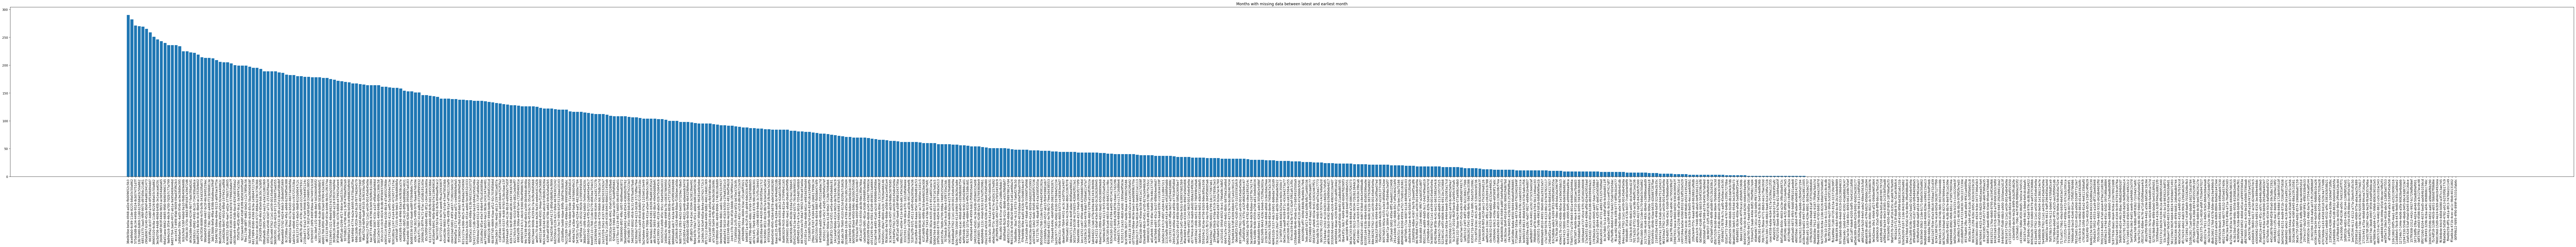

In [24]:
plt.figure(figsize=(150, 10))
plt.bar(missing_month_df["datasetKey"], missing_month_df["missingMonths"])
plt.title("Months with missing data between latest and earliest month")
plt.xticks(rotation=90)
plt.show()

##### Interpretation
Missing months represent months between a dataset’s earliest and latest record in which no occurrence data appears in the aggregated file.

This may reflect:
1. True absence of recorded insect occurrences
2. Dataset inactivity during those months
3. Reporting or publication gaps

This confirms that the dataset is not a balanced panel. It is an unbalanced, irregularly sampled observational system, which has implications for:
* Rolling stability calculations
* Structural break detection
* Forecast reliability
* Anomaly interpretation

### Cardinality and Density

#### Global Panel Density

In [25]:
n_datasets = df["datasetKey"].nunique()

n_months_global = (df["date"].max().year - df["date"].min().year) * 12

theoretical_max_rows = n_datasets * n_months_global
actual_rows = len(df)

density = actual_rows / theoretical_max_rows
density

0.18814639283833598

The global panel density is approximately 0.19.

This means that only about 19% of all possible (dataset × month) combinations within the study window contain observations. Roughly 81% of the theoretical panel is empty.

##### Interpretation
The dataset forms a **highly sparse and unbalanced panel**.

This has immediate methodological implications:
* Classical panel regression assuming a balanced panel is inappropriate.
* Per-dataset time-series modelling will be infeasible for many datasets due to limited observations.
* Aggregated modelling may be more stable than dataset-level modelling.

These are structural observations based on panel sparsity, not yet conclusions about dominance or influence.

#### Within-Dataset Density 

We now measure density within each dataset’s active span.

In [26]:
density_df = df.groupby("datasetKey")["date"].agg(["min", "max", "count"])

density_df["duration_months"] = (
    (density_df["max"].dt.year - density_df["min"].dt.year) * 12
    + (density_df["max"].dt.month - density_df["min"].dt.month)
    + 1
)

density_df["density"] = density_df["count"] / density_df["duration_months"]

density_df.drop(columns=["min", "max"], inplace=True)

density_df.describe()


count  duration_months     density
count  633.000000       633.000000  633.000000
mean    56.443918       112.338073    0.579289
std     84.294149       110.464595    0.372246
min      1.000000         1.000000    0.009302
25%      2.000000         3.000000    0.205479
50%     10.000000        73.000000    0.609467
75%     81.000000       203.000000    1.000000
max    312.000000       312.000000    1.000000

##### Summary Statistics
* Median active months (`count`): 10
* Median duration: 73 months
* Median density: ~0.61
* 25th percentile density: ~0.21
* 75th percentile density: 1.00

##### Interpretation
Within-dataset density varies substantially:
* Some datasets are nearly continuous within their active span (density = 1).
* Others are highly intermittent (density < 0.01).
* At least 25% of datasets are continuous across their active duration.

This confirms that sparsity arises from two mechanisms:
* Short overall lifespan.
* Intermittent sampling within longer lifespans.

##### Structural Conclusion at This Stage

We can now confidently say:
* The system is an unbalanced, sparse observational panel.
* Temporal continuity varies significantly across datasets.
* Dataset-level modelling will require filtering or aggregation.

We have not yet established:
* Contribution concentration
* Structural dominance
* Influence on aggregate trends

Those remain open analytical questions.

## Distributional Structure

### Raw Distribution of Monthly Occurrence Counts

In [27]:
df["occurrenceCount"].describe()

count     35729.000000
mean       1647.607490
std       15237.856954
min           1.000000
25%           4.000000
50%          27.000000
75%         187.000000
max      544130.000000
Name: occurrenceCount, dtype: float64

##### Summary statistics:
* Count: 35,729
* Mean: 1,647
* Median: 27
* Standard deviation: 15,238
* Minimum: 1
* Maximum: 544,130

Selected quantiles: 

In [28]:
df["occurrenceCount"].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50       27.00
0.75      187.00
0.90      951.20
0.95     2549.40
0.99    31944.24
Name: occurrenceCount, dtype: float64

* 50th percentile: 27
* 75th percentile: 187
* 90th percentile: ~951
* 95th percentile: ~2,549
* 99th percentile: ~31,944

##### Interpretation
The distribution is extremely right-skewed:
* The mean (1,647) is roughly 61× larger than the median (27).
* The 99th percentile (~31,944) is more than 1,000× larger than the median.
* The maximum value exceeds 500,000.

This indicates the presence of very large observations relative to the bulk of the data. The variance is dominated by a small number of extreme months.

### Log-Scaled Distribution

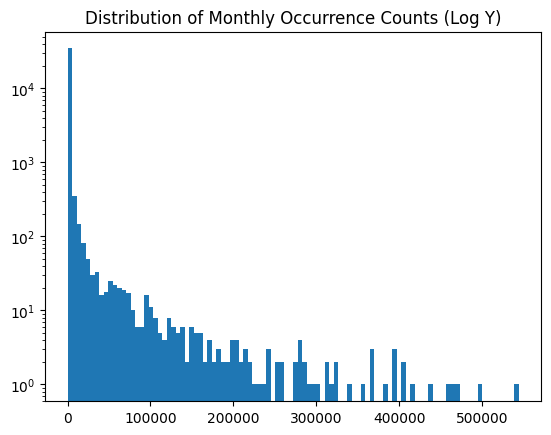

In [29]:
plt.hist(df["occurrenceCount"], bins=100)
plt.yscale("log")
plt.title("Distribution of Monthly Occurrence Counts (Log Y)")
plt.show()

Using a logarithmic y-axis reveals the heavy-tailed structure more clearly. The majority of observations cluster at low counts, with a long tail extending toward very large values.

##### Structural Implication

The heavy right skew suggests:
* Log transformation or robust modelling approaches may be necessary.
* Aggregated totals may be sensitive to extreme observations.

This confirms that the system exhibits strong distributional imbalance.

### Skewness and Kurtosis

In [30]:
df["occurrenceCount"].skew()

np.float64(18.23312771081628)

Skewness ≈ 18.23

In [31]:
df["occurrenceCount"].kurt()

np.float64(413.255935225466)

Excess Kurtosis ≈ 413.26

##### Interpretation

These values are extremely large relative to what would be expected under a normal distribution:
* A normal distribution has skewness = 0.
* A normal distribution has excess kurtosis = 0.

A skewness of 18 indicates severe right-tail asymmetry.
A kurtosis above 400 indicates an extremely heavy-tailed distribution with extreme outliers.

This confirms quantitatively what was observed in the summary statistics:
* The distribution is dominated by a small number of very large values.
* Variance is not evenly distributed across observations.
* Standard parametric assumptions (normal errors, finite variance behavior) will be inappropriate without transformation.

##### Modelling Implication
Given this distributional structure:
* Log transformation is likely necessary.
* Robust or non-Gaussian models (e.g., Poisson/Negative Binomial frameworks) may be more appropriate depending on aggregation level.
* Aggregated totals may be sensitive to a small number of extreme observations.

At this stage, we have formally established that the data is highly non-normal and heavy-tailed.

### Dataset-Level Total Contribution

In [32]:
df_dataset_totals = df.groupby("datasetKey")["occurrenceCount"].sum().sort_values(ascending=False)

share_top_10 = df_dataset_totals.head(10).sum() / df_dataset_totals.sum()
share_top_1pct = df_dataset_totals.head(int(len(df_dataset_totals) * 0.01)).sum() / df_dataset_totals.sum()

share_top_10, share_top_1pct

(np.float64(0.8459004316279267), np.float64(0.8079004313561292))

##### Concentration Results
* Top 10 datasets account for 84.6% of all occurrences.
* Top 1% of datasets (≈6 datasets) account for 80.8% of all occurrences.

This is extreme contribution concentration.

#### Cumulative Contribution Curve

In [33]:
cumulative_x = (np.arange(1, len(df_dataset_totals)+1)) / len(df_dataset_totals)
cumulative_y = df_dataset_totals.cumsum() / df_dataset_totals.sum()

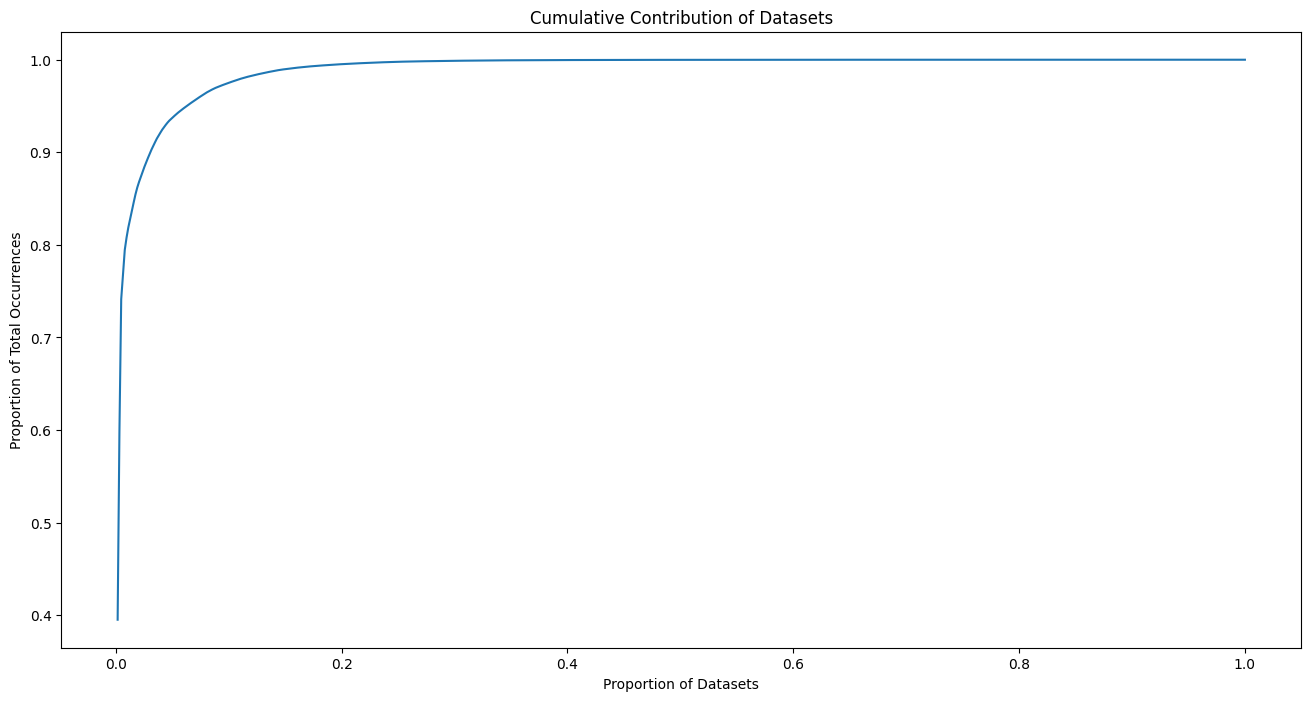

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(cumulative_x, cumulative_y)
plt.title("Cumulative Contribution of Datasets")
plt.xlabel("Proportion of Datasets")
plt.ylabel("Proportion of Total Occurrences")
plt.show()

The resulting curve resembles a Lorenz curve and confirms an extremely unequal distribution.

##### Interpretation

We can now formally establish:
* The observational system is **highly concentrated**.
* A very small number of datasets dominate total insect occurrence counts.
* The majority of datasets contribute negligibly to total volume.

This validates the earlier distributional findings:
* The heavy right tail in monthly counts is consistent with dominance by a few very large datasets.
* Aggregate trends are likely to be structurally influenced by these dominant contributors.

##### Structural Implication
From a modelling perspective:
1. Aggregate time-series behaviour will largely reflect the dynamics of a small core of datasets.
2. Structural breaks in those datasets could significantly impact global forecasts.
3. Robustness checks should include:
    * Removing top contributors
    * Re-weighting
    * Stratified aggregation

### Dominance decomposition

Global biodiversity occurrence trends are heavily influenced by a small subset of datasets. Understanding the contribution of dominant datasets is critical before interpreting aggregate trends, as a few long-running, large datasets can disproportionately shape the overall signal.

#### Yearly Occurrences by Dominance Tier

We define the **Top 1% of datasets** based on total occurrences and group all other datasets as the **Bottom 99%**. This allows us to quantify how dominance affects yearly occurrence counts.

In [35]:
# Identify top 1% datasets
n_top = int(len(df_dataset_totals) * 0.01)
top_keys = df_dataset_totals.head(n_top).index

In [36]:
# Add dominance tier to the main dataframe
df["tier"] = df["datasetKey"].isin(top_keys)

In [37]:
# Aggregate yearly occurrences by tier
tier_yearly = df.groupby(["year", "tier"])["occurrenceCount"].sum().reset_index()
tier_pivot = tier_yearly.pivot(index="year", columns="tier", values="occurrenceCount")
tier_pivot.columns = ["Bottom 99%", "Top 1%"]

In [38]:
tier_pivot.head()

Bottom 99%   Top 1%
year                     
2000      341490  1033716
2001      263630   979676
2002      308922  1228211
2003      336848  1648541
2004      328749  1631495

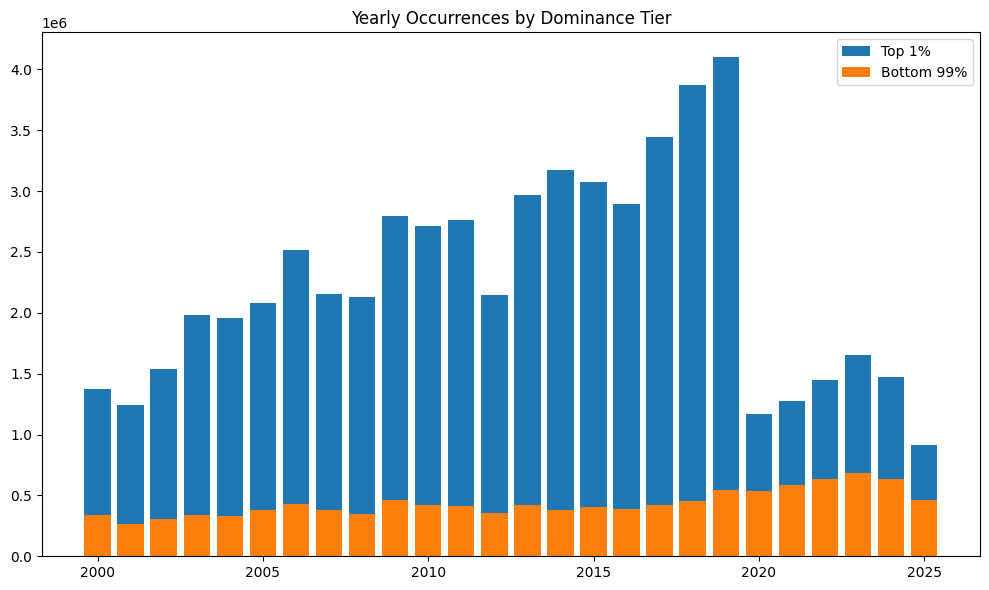

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(tier_pivot.index, tier_pivot["Top 1%"], bottom=tier_pivot["Bottom 99%"], label="Top 1%")
plt.bar(tier_pivot.index, tier_pivot["Bottom 99%"], label="Bottom 99%")
plt.legend()
plt.title("Yearly Occurrences by Dominance Tier")
plt.tight_layout()
plt.show()

Stacked bar chart showing yearly occurrences for Top 1% and Bottom 99% of datasets.

##### Observations:

* The **Top 1% of datasets dominate total occurrences**, often exceeding the contributions of the Bottom 99%.
* There is a **sharp decline in 2020 and onwards**, almost entirely driven by the Top 1%.
* The Bottom 99% shows only minor variation, suggesting the observed drop in total occurrences is **not an ecological signal** but likely due to reporting changes.

##### Interpreting the Dominance Effect
Possible explanations for the post-2020 drop include:
1. **Institutional reporting lag**: Large datasets may take longer to publish new data.
2. **Major dataset discontinuation**: One or more dominant datasets may have stopped reporting.
3. **COVID-era collection disruption**: Fieldwork and reporting may have been interrupted.

##### Conclusion
* Any analysis of aggregate global trends must account for the **disproportionate influence of dominant datasets**.
* Interpretation of apparent declines or increases in biodiversity occurrences should consider reporting patterns and dataset activity.

#### Plot Mean Occurrence by Dataset per Tier

We calculate the **mean occurrences per dataset** for each dominance tier (Top 1% vs. Bottom 99%) by year. This metric accounts for differences in the number of active datasets each year.

In [40]:
# Count active datasets per year and tier
active_counts = df.groupby(["year", "tier"])["datasetKey"].nunique().reset_index(name="activeDatasets")

In [41]:
# Merge with yearly occurrence sums
tier_yearly = tier_yearly.merge(active_counts, on=["year", "tier"])
tier_yearly["meanPerDataset"] = tier_yearly["occurrenceCount"] / tier_yearly["activeDatasets"]

In [42]:
# Pivot for plotting
tier_pivot = tier_yearly.pivot(index="year", columns="tier", values="meanPerDataset")
tier_pivot.columns = ["Bottom 99%", "Top 1%"]

In [43]:
tier_pivot.head()

Bottom 99%         Top 1%
year                            
2000  1698.955224  172286.000000
2001  1279.757282  163279.333333
2002  1436.846512  204701.833333
2003  1619.461538  274756.833333
2004  1501.136986  271915.833333

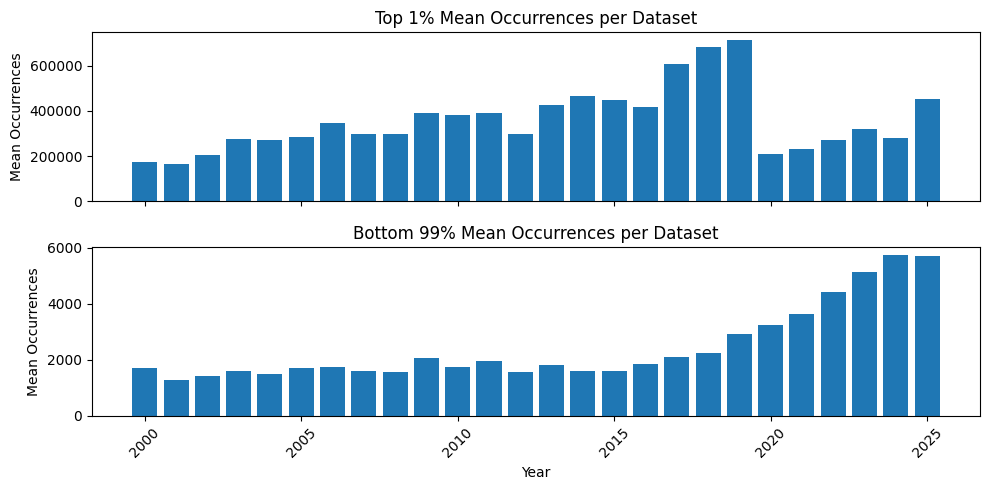

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Top 1%
axes[0].bar(
    tier_pivot.index,
    tier_pivot["Top 1%"]
)
axes[0].set_title("Top 1% Mean Occurrences per Dataset")
axes[0].set_ylabel("Mean Occurrences")

# Bottom 99%
axes[1].bar(
    tier_pivot.index,
    tier_pivot["Bottom 99%"]
)
axes[1].set_title("Bottom 99% Mean Occurrences per Dataset")
axes[1].set_ylabel("Mean Occurrences")
axes[1].set_xlabel("Year")

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

Yearly mean occurrences per dataset for Top 1% and Bottom 99% tiers.

##### Interpretation
* **Top 1%**: Mean occurrences per dataset **collapse sharply after 2020** and do not fully recover, indicating that the decline is concentrated in the dominant datasets.

* **Bottom 99%**: Mean occurrences per dataset **steadily increase from 2015 onward**, suggesting smaller contributors are becoming more active or efficient.

##### Implications:
1. The 2020 drop is **not a broad biodiversity decline**.
2. It is unlikely caused by **universal sampling collapse** or **platform-wide reporting failures**.
3. There is likely a **behavioral or reporting shift among major contributors**.
4. Growth in the Bottom 99% indicates:
    * Increased participation by smaller contributors
    * Improved digitization pipelines
    * Growth of citizen-science contributions

##### Conclusion
The dataset shows **structural decentralization**: the dominant Top 1% are declining in reporting intensity, while smaller datasets are growing, reshaping the distribution of contributions over time.

#### Plot Occurrence Count per Dataset

We now examine individual top 1% datasets to see how their contributions evolve over time. This allows us to identify which datasets drive the global trends, especially the post-2020 decline.

In [45]:
# Aggregate yearly occurrences per top dataset
top_yearly_df = df[df["tier"] == True].groupby(["datasetKey", "year"])["occurrenceCount"].sum().reset_index()
top_yearly_df.head()

datasetKey  year  occurrenceCount
0  1270b3c8-ff55-4b63-a407-dcd7e08cd23f  2000            31032
1  1270b3c8-ff55-4b63-a407-dcd7e08cd23f  2001            31347
2  1270b3c8-ff55-4b63-a407-dcd7e08cd23f  2002            35399
3  1270b3c8-ff55-4b63-a407-dcd7e08cd23f  2003            43607
4  1270b3c8-ff55-4b63-a407-dcd7e08cd23f  2004            33957

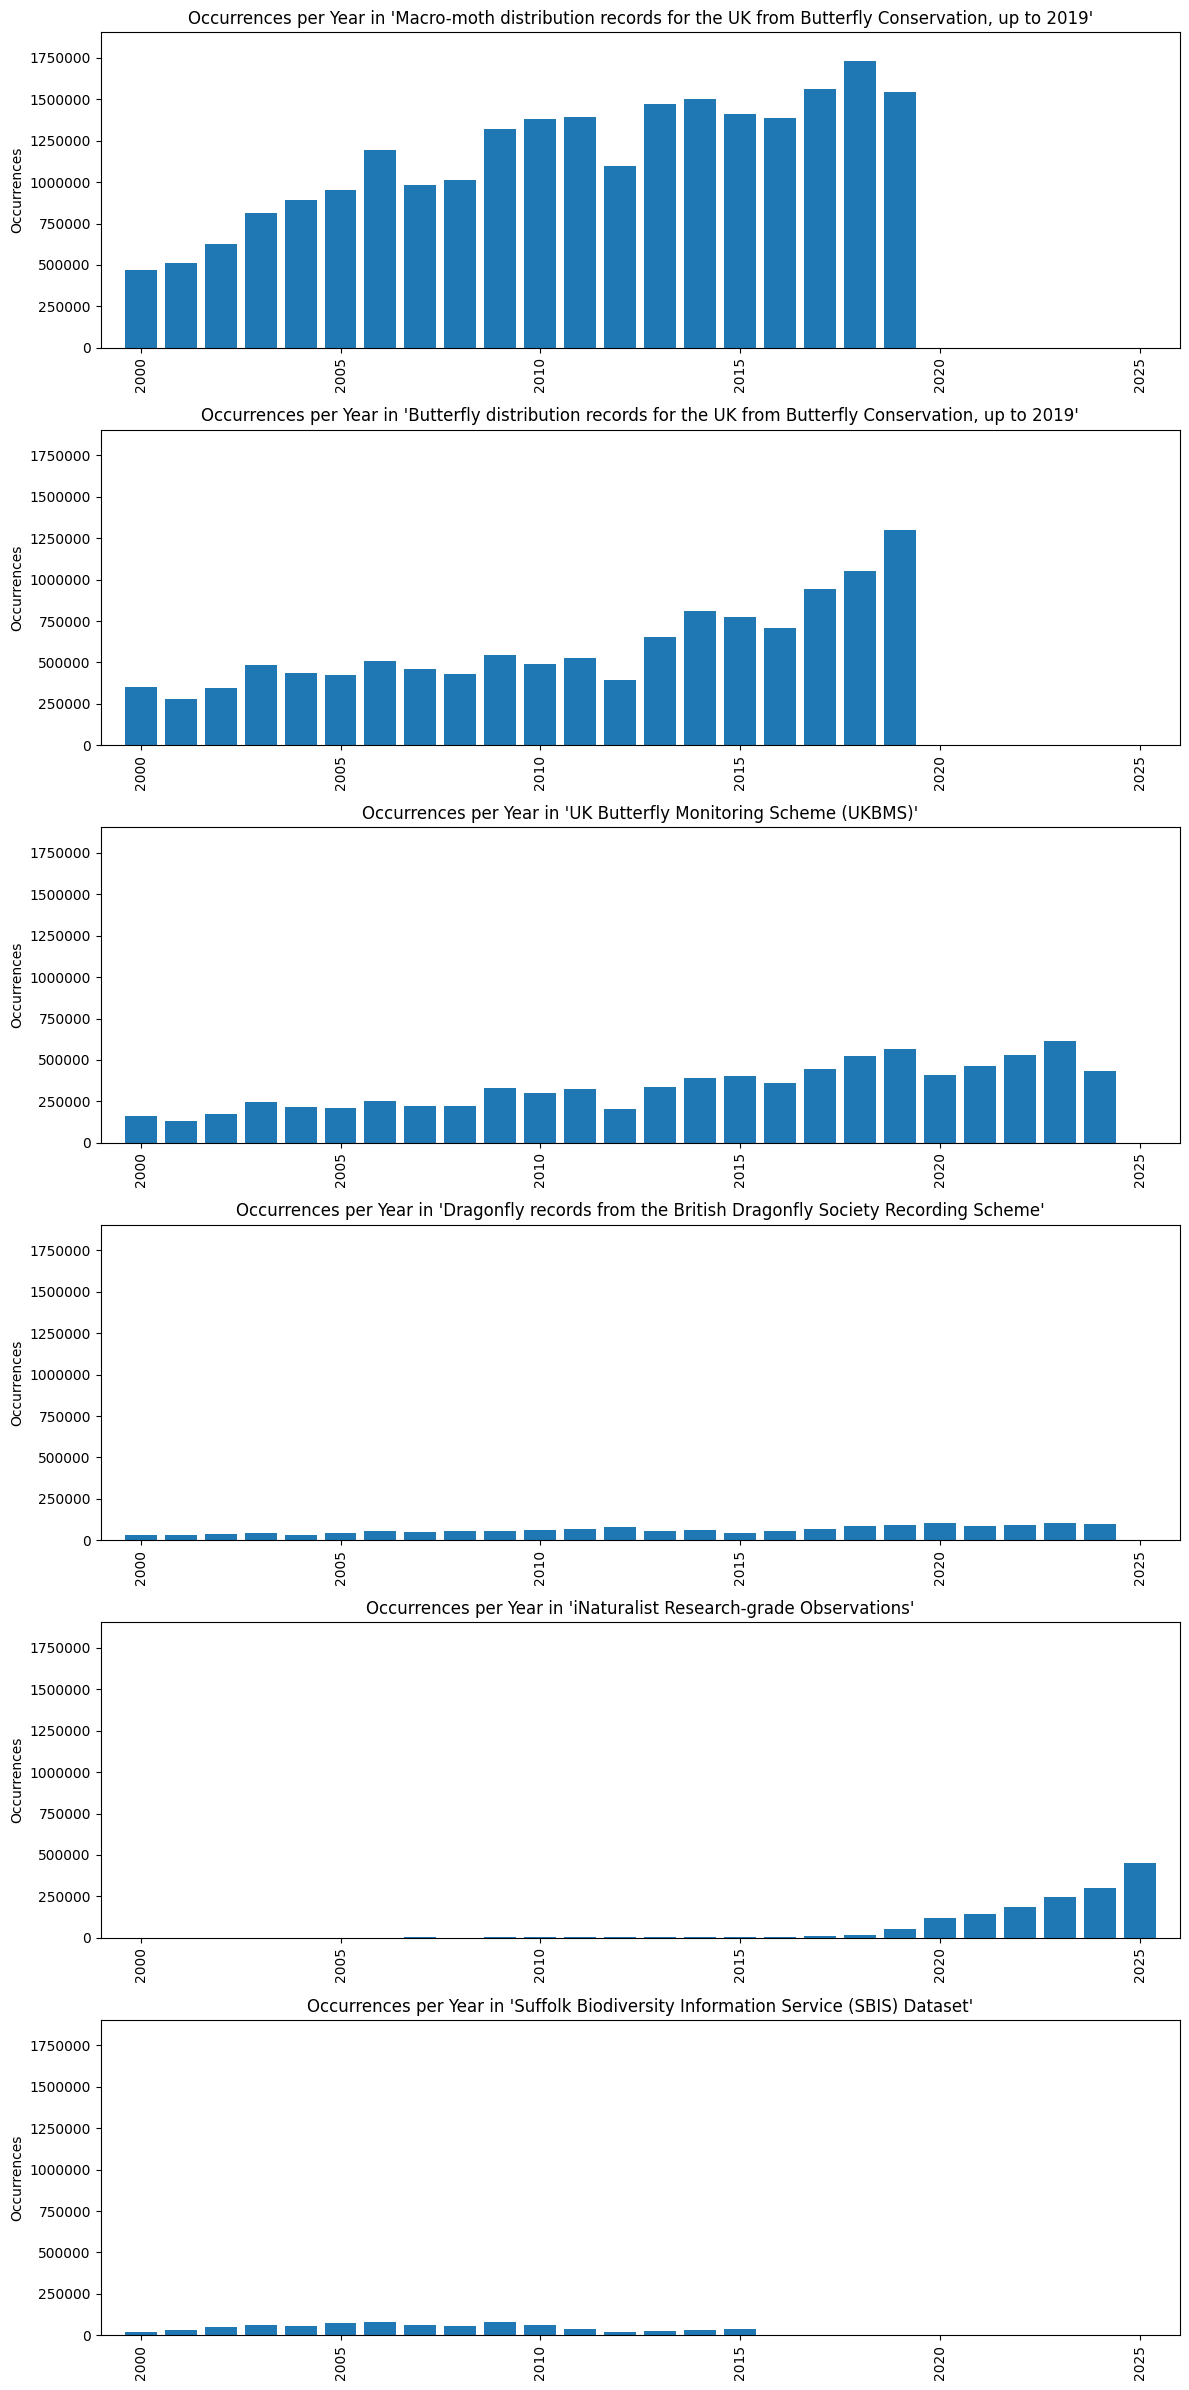

In [46]:
fig, axes = plt.subplots(len(top_keys), 1, figsize=(12, 4 * len(top_keys)), sharex=False)

global_xmin = top_yearly_df["year"].min()
global_xmax = top_yearly_df["year"].max()
global_ymax = top_yearly_df["occurrenceCount"].max()
global_ymin = 0

# Ensure axes iterable if only one dataset
if len(top_keys) == 1:
    axes = [axes]

for i, key in enumerate(top_keys):
    key_yearly_df = top_yearly_df[top_yearly_df["datasetKey"] == key].drop(columns=["datasetKey"])
    axes[i].bar(key_yearly_df["year"], key_yearly_df["occurrenceCount"])
    axes[i].set_title(f"Occurrences per Year in '{dataset_title_lookup[key]}'")
    axes[i].set_ylabel("Occurrences")
    axes[i].set_ylim(global_ymin, global_ymax * 1.1)
    axes[i].set_xlim(global_xmin - 1, global_xmax + 1)
    axes[i].ticklabel_format(style="plain", axis="y")
    axes[i].tick_params(axis="x", rotation=90)

fig.tight_layout()
plt.show()

Yearly occurrence counts for all Top 1% datasets.

##### Interpretation
* The **largest 2 datasets end in 2019** and account for a **major proportion of the Top 1% records**.
* The sharp **post-2020 decline** in global occurrences is almost entirely due to these two datasets ending, **not ecological or reporting collapse**.

##### Implications for analysis:

1. **Remove closed historical archives**
    * Exclude datasets that end before the present
    * Exclude datasets that are no longer continuously updated
2. **Restrict analysis to a sensible time window**
    * Analyze data **up to 2019**
    * Analyze data **post-2019** if focusing on active datasets

This decomposition confirms that **a small number of dominant datasets drive global trends**, reinforcing the need to account for dataset-specific lifecycle effects in any trend analysis.

## Global Reporting Trend

We examine how the total reported occurrences change over time, first across all datasets, then after removing dominant or inactive datasets to better isolate persistent reporting patterns.

### All datasets (raw)

In [47]:
df_yearly = df.groupby(["year"])["occurrenceCount"].sum().reset_index()

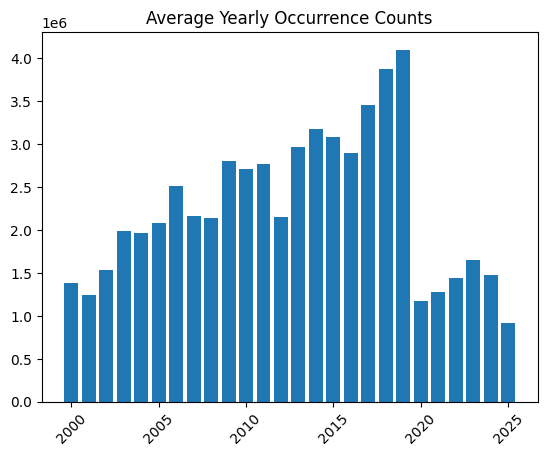

In [48]:
plt.bar(df_yearly["year"], df_yearly["occurrenceCount"])
plt.title("Average Yearly Occurrence Counts")
plt.xticks(rotation=45)
plt.show()

##### Observation
There is a **sharp decline in total occurrences after 2019**, consistent with our previous dominance decomposition analysis.

### Remove top 2 datasets

We remove the **largest two datasets** that ended in 2019 to see their impact on the global trend.

In [49]:
df_yearly_drop_top = df[(df["datasetKey"] != top_keys[0]) & (df["datasetKey"] != top_keys[1])].groupby(["year"])["occurrenceCount"].sum().reset_index()

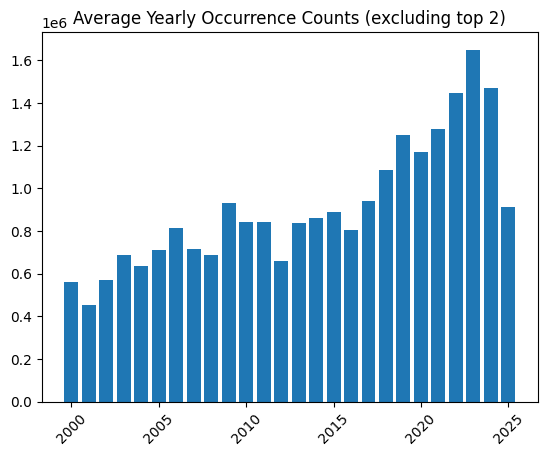

In [50]:
plt.bar(df_yearly_drop_top["year"], df_yearly_drop_top["occurrenceCount"])
plt.title("Average Yearly Occurrence Counts (excluding top 2)")
plt.xticks(rotation=45)
plt.show()

##### Observation
* Removing the top 2 datasets **eliminates the post-2019 collapse**.
* A positive trend in total occurrences is visible, indicating that the decline in the raw trend is **driven by these dominant datasets ending**, not a system-wide reporting failure.

### Remove all datasets that aren't active post-2019

We further restrict the panel to datasets that are active beyond 2019, excluding left-censored or historical-only datasets.

In [51]:
dataset_yearly_df = df.groupby(["datasetKey", "year"])["occurrenceCount"].sum().reset_index()
dataset_yearly_df = dataset_yearly_df[dataset_yearly_df['year'] > 2019]
active_datasets = dataset_yearly_df['datasetKey'].unique()

In [52]:
df['activePost2019'] = df['datasetKey'].isin(active_datasets)

In [53]:
df_yearly_drop_inactive = df[(df["activePost2019"] == True)].groupby(["year"])["occurrenceCount"].sum().reset_index()

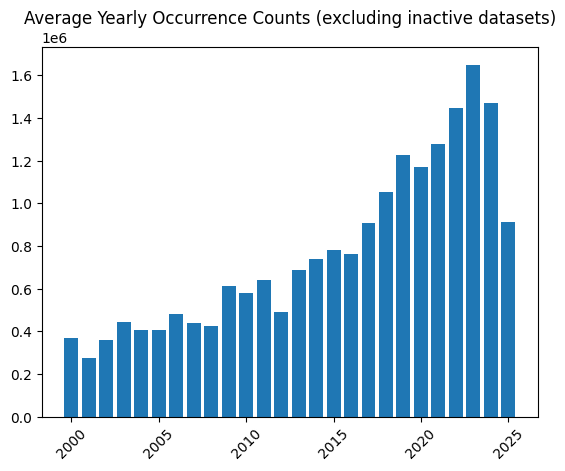

In [54]:
plt.bar(df_yearly_drop_inactive["year"], df_yearly_drop_inactive["occurrenceCount"])
plt.title("Average Yearly Occurrence Counts (excluding inactive datasets)")
plt.xticks(rotation=45)
plt.show()

##### Observation
* Filtering out inactive datasets shows a **clear upward trend with less noise**.
* This approach effectively removes **left-censored historical archives, one-off digitisation projects, and closed institutional dumps**, giving a **more meaningful view of active reporting trends**.

## Seasonal Decomposition

We now examine the **within-year seasonal patterns** in reporting, measuring how occurrences vary by month.

### Raw Seasonal Decomposition

We compute the **average occurrences per month** across the full dataset.

In [55]:
df_month = df.drop(columns=['datasetKey', 'year', 'speciesRichness', 'date', 'tier', 'activePost2019'])
df_month = df_month.groupby('month').agg("mean")
df_month

occurrenceCount
month                 
1            57.460610
2           108.522716
3           415.507698
4          1003.697183
5          1630.577766
6          2654.314666
7          4371.960486
8          3185.712584
9          1512.482234
10          621.866822
11          188.256591
12           88.089436

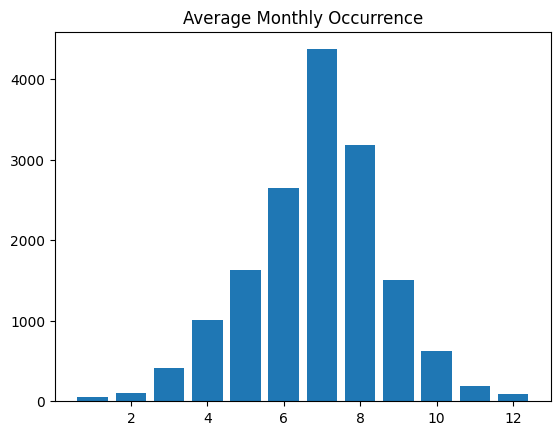

In [56]:
plt.bar(df_month.index, df_month["occurrenceCount"])
plt.title("Average Monthly Occurrence")
plt.show()

##### Observation
* Reporting is highly seasonal, peaking in mid-year (months 6–7) and lowest in winter months (1, 12).
* This seasonal pattern is consistent across datasets.

#### Quantifying Seasonality

We can measure seasonality using two metrics

1. Seasonality Strength:
$seasonalityStrength = \frac{max(monthlyMean) - min(monthlyMean)}{mean(monthlyMean)}$

In [57]:
seasonality_strength_overall = (np.max(df_month['occurrenceCount']) - np.min(df_month['occurrenceCount']) )/ np.mean(df_month['occurrenceCount'])
seasonality_strength_overall

np.float64(3.2688806337581324)

Result: ≈ 3.27, indicating the difference between peak month and the minimum month is over 3 times the average month, a very pronounced seasonal signal.

2. Peak Share:
$peakShare= \frac{max(monthlyMean)}{sum(monthlyMean)}$

In [58]:
peak_share_overall = np.max(df_month['occurrenceCount']) / np.sum(df_month['occurrenceCount'])
peak_share_overall

np.float64(0.2760346384954211)

Result: ≈ 0.276, meaning the single highest month accounts for ~28% of total yearly reporting.

##### Interpretation
* Reporting intensity is strongly concentrated in the mid-year months.
* This will be useful when comparing seasonal patterns **between dominance tiers** or **active/inactive datasets**, which will be explored in the next subsection.

### Charting Seasonality by Dataset

We now quantify **seasonal patterns at the dataset level**. Each dataset is assessed for:
1. **Seasonality strength** – how concentrated occurrences are in peak months relative to the mean.
2. **Peak share** – the proportion of total yearly occurrences occurring in the peak month.

In [59]:
results = []

for key in df_dataset_totals[df_dataset_totals > 100].index:
    subset = df[df['datasetKey'] == key]
    df_subset_month = subset.drop(columns=['datasetKey', 'year', 'speciesRichness', 'date', 'tier', 'activePost2019'])
    df_subset_month = df_subset_month.groupby('month').agg("mean")
    
    seasonality_strength = (np.max(df_subset_month['occurrenceCount']) - np.min(df_subset_month['occurrenceCount']) )/ np.mean(df_subset_month['occurrenceCount'])
    peak_share = np.max(df_subset_month['occurrenceCount']) / np.sum(df_subset_month['occurrenceCount'])
    
    results.append({"datasetKey": key, "seasonalityStrength": seasonality_strength, "peakShare": peak_share})

seasonality_df = pd.DataFrame(results)

seasonality_df['datasetName'] = seasonality_df['datasetKey'].map(dataset_title_lookup)
seasonality_df['count'] = df_dataset_totals.loc[seasonality_df['datasetKey']].values
seasonality_df['label'] = seasonality_df['datasetKey'] + " (" + seasonality_df['count'].astype(str) + ")"

seasonality_df

datasetKey  seasonalityStrength  peakShare  \
0    a86201a4-fa20-44e5-ade2-68ea3563cfa8             3.414000   0.286133   
1    d59ea6f3-f758-4d84-8c90-be078629127e             3.970378   0.331287   
2    1e266c3d-92ef-4d5a-8e4a-c04742c772c3             3.143229   0.349274   
3    1270b3c8-ff55-4b63-a407-dcd7e08cd23f             3.145325   0.262331   
4    50c9509d-22c7-4a22-a47d-8c48425ef4a7             2.688960   0.227446   
..                                    ...                  ...        ...   
317  82b73cc2-9e3f-46d0-a836-c647383d7c88             2.155374   0.292056   
318  b0c91373-f373-40e5-98df-6320d9047c2c             3.150000   0.475000   
319  60920f60-eff7-409d-884b-fba96b3c7fe6             2.644444   0.400000   
320  833951d4-633b-49b4-b06c-85d00396ea9e             3.217877   0.413408   
321  c497c84a-ba5e-439d-8932-b23df520e529             0.653465   0.663366   

                                           datasetName     count  \
0    Macro-moth distribution records for the UK fro...  23252500   
1    Butterfly distribution records for the UK from...  11923833   
2               UK Butterfly Monitoring Scheme (UKBMS)   8457532   
3    Dragonfly records from the British Dragonfly S...   1579424   
4              iNaturalist Research-grade Observations   1559875   
..                                                 ...       ...   
317            Records 2004-2022 by Rosemary Etheridge       113   
318                            Heleomyzidae of Ireland       112   
319  PTES - incidental Coleoptera records from the ...       103   
320           Ants: Formica Exsecta Records (Scotland)       102   
321  SNH Invertebrate Site Condition Monitoring 201...       101   

                                               label  
0    a86201a4-fa20-44e5-ade2-68ea3563cfa8 (23252500)  
1    d59ea6f3-f758-4d84-8c90-be078629127e (11923833)  
2     1e266c3d-92ef-4d5a-8e4a-c04742c772c3 (8457532)  
3     1270b3c8-ff55-4b63-a407-dcd7e08cd23f (1579424)  
4     50c9509d-22c7-4a22-a47d-8c48425ef4a7 (1559875)  
..                                               ...  
317       82b73cc2-9e3f-46d0-a836-c647383d7c88 (113)  
318       b0c91373-f373-40e5-98df-6320d9047c2c (112)  
319       60920f60-eff7-409d-884b-fba96b3c7fe6 (103)  
320       833951d4-633b-49b4-b06c-85d00396ea9e (102)  
321       c497c84a-ba5e-439d-8932-b23df520e529 (101)  

[322 rows x 6 columns]

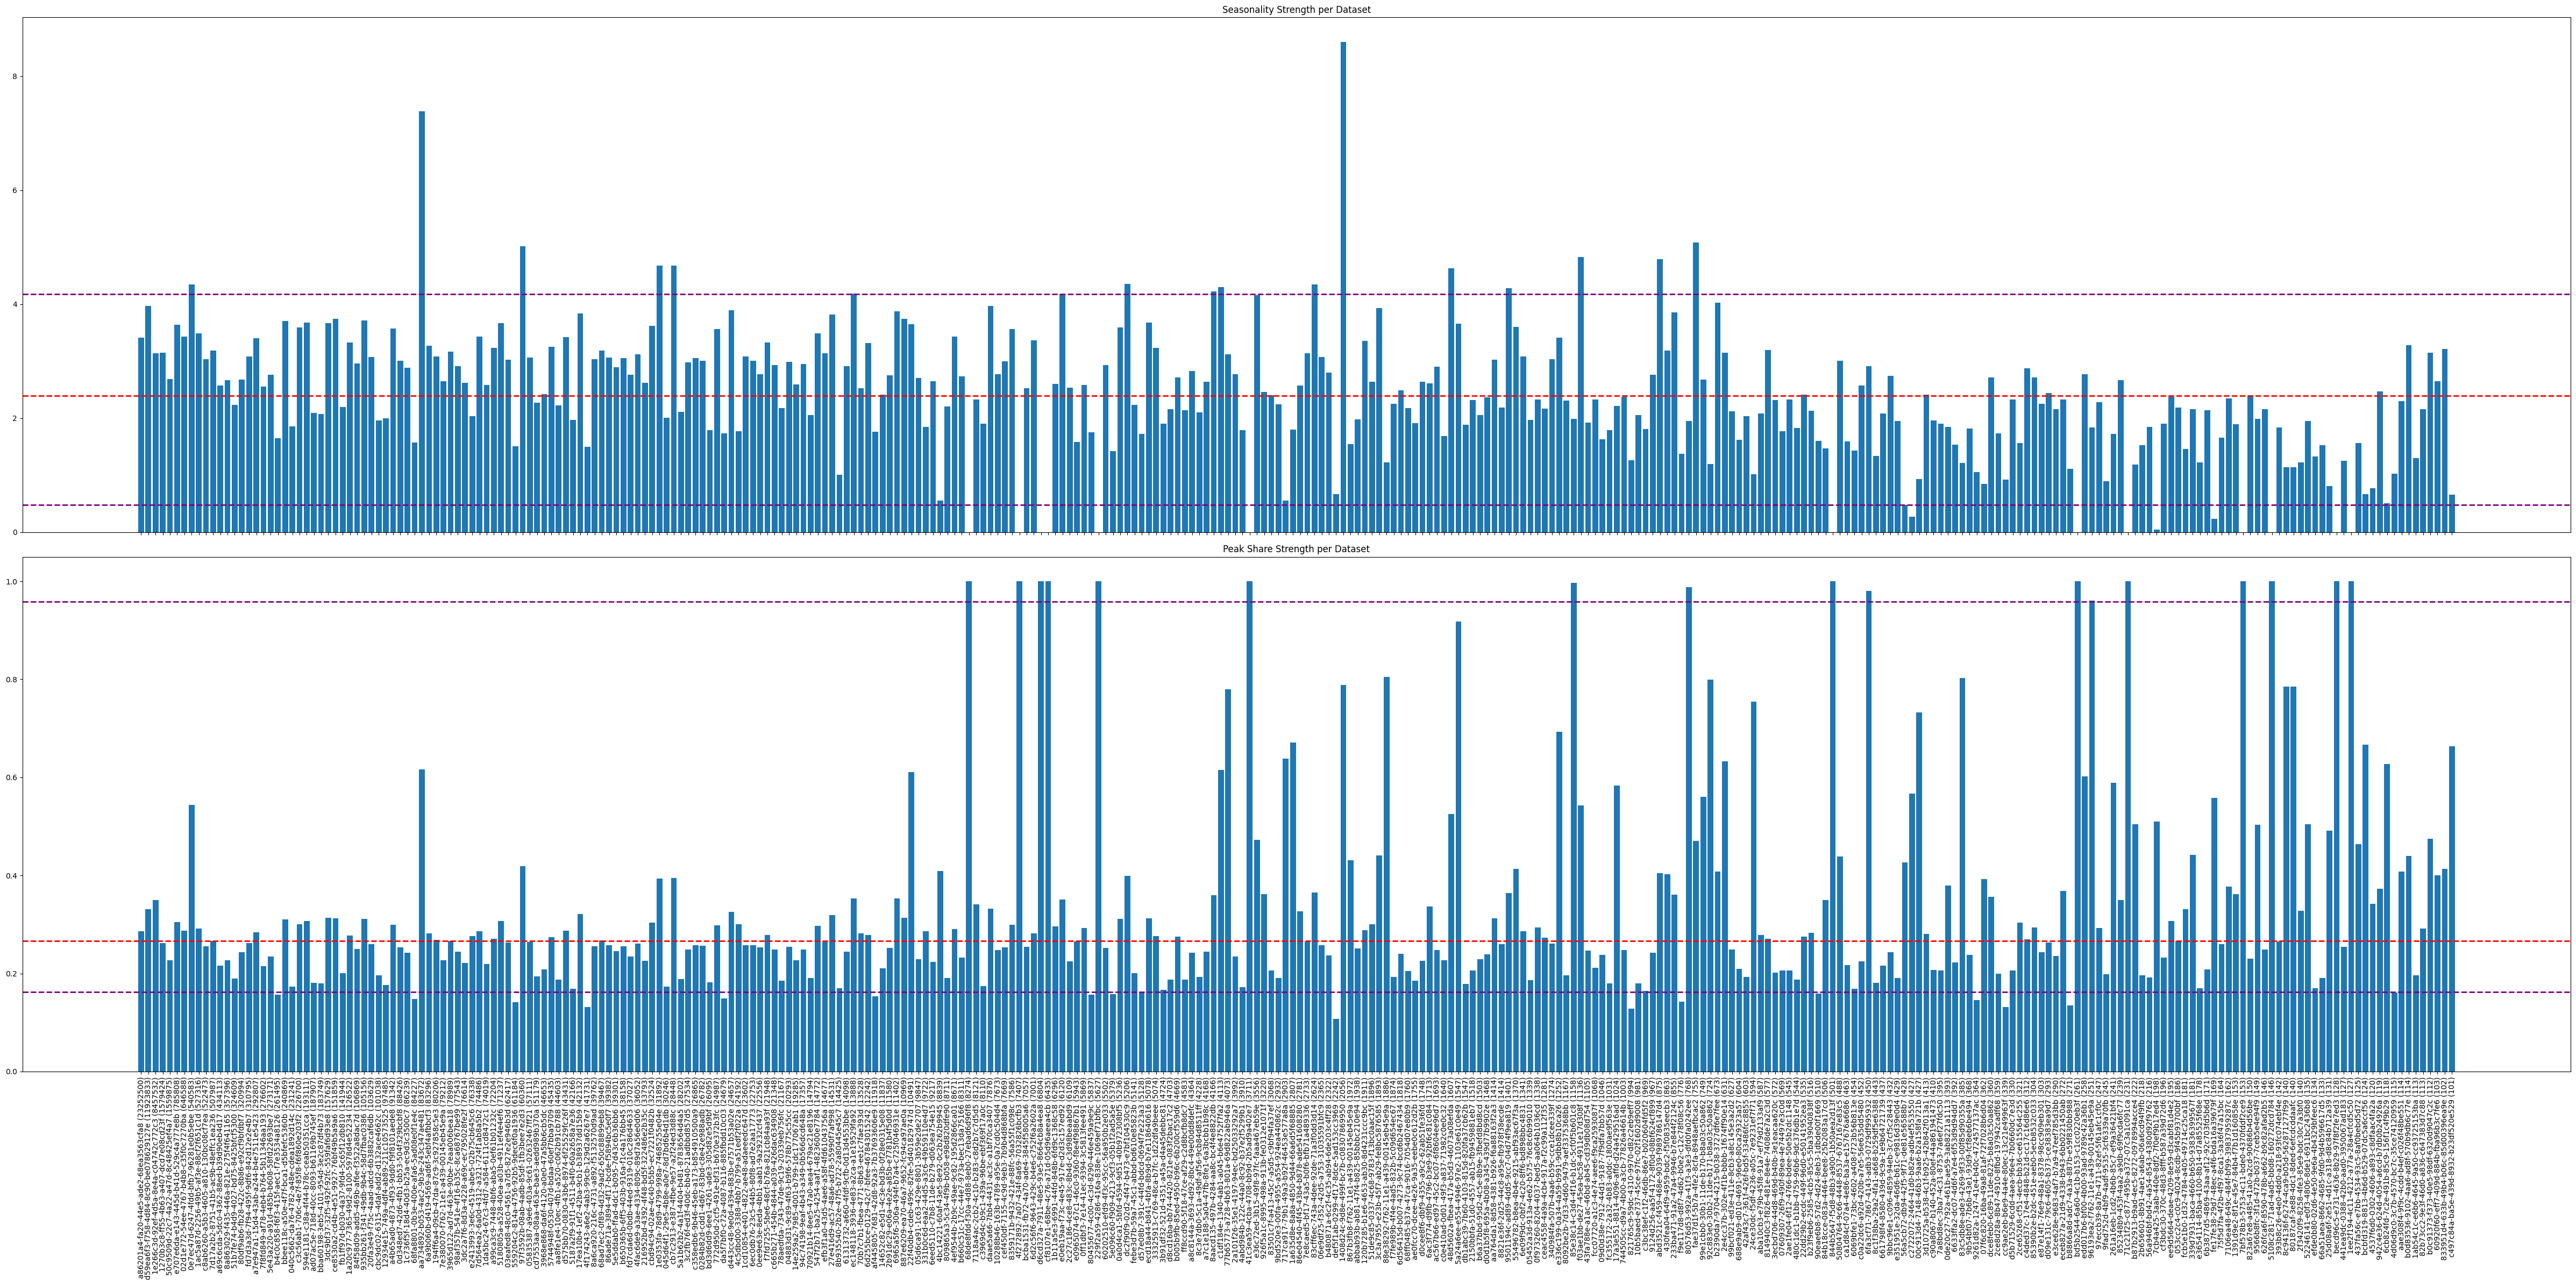

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(48, 24), sharex=True)

axes[0].bar(seasonality_df['label'], seasonality_df["seasonalityStrength"])
axes[0].set_title("Seasonality Strength per Dataset")
axes[0].axhline(seasonality_df['seasonalityStrength'].median(), linestyle="--", linewidth=2, color="red")
axes[0].axhline(seasonality_df['seasonalityStrength'].quantile(0.05), linestyle="--", linewidth=2, color="purple")
axes[0].axhline(seasonality_df['seasonalityStrength'].quantile(0.95), linestyle="--", linewidth=2, color="purple")

axes[1].bar(seasonality_df['label'], seasonality_df["peakShare"])
axes[1].set_title("Peak Share Strength per Dataset")
axes[1].axhline(seasonality_df['peakShare'].median(), linestyle="--", linewidth=2, color="red")
axes[1].axhline(seasonality_df['peakShare'].quantile(0.05), linestyle="--", linewidth=2, color="purple")
axes[1].axhline(seasonality_df['peakShare'].quantile(0.95), linestyle="--", linewidth=2, color="purple")

plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

In [61]:
seasonality_df.describe()

seasonalityStrength   peakShare         count
count           322.000000  322.000000  3.220000e+02
mean              2.427193    0.341375  1.827963e+05
std               1.129579    0.209288  1.530772e+06
min               0.000000    0.107285  1.010000e+02
25%               1.800976    0.217533  4.447500e+02
50%               2.393561    0.265952  2.794000e+03
75%               3.080921    0.362089  2.491000e+04
max               8.603644    1.000000  2.325250e+07

##### Interpretation
* Most datasets exhibit moderate seasonality, with the median strength ≈ 2.39.
* The top datasets show very strong seasonality.
* Peak months can contribute up to 100% of total occurrences in extremely small datasets, indicating single-month digitization or one-off events.
* Larger datasets tend to show consistent seasonal cycles without extreme concentration.

##### Conclusion
Seasonality varies substantially across datasets, but the median behavior shows a consistent mid-year peak, supporting earlier aggregated seasonal patterns. This sets the stage for tier-based or active dataset seasonal analyses.

In [62]:
df_month = df.drop(columns=['year', 'speciesRichness', 'date', 'tier', 'activePost2019'])
df_month = df_month.groupby(['datasetKey', 'month']).agg("mean").reset_index()

#### High-Seasonality Datasets

By focusing on datasets in the top 5% for seasonality strength, we can observe detailed, species-specific seasonal patterns.

In [63]:
high_strength_df = seasonality_df[seasonality_df["seasonalityStrength"] > seasonality_df["seasonalityStrength"].quantile(0.95)]
high_strength_df

datasetKey  seasonalityStrength  peakShare  \
7    0e7ec47d-6247-4fdd-bfb7-96281e0b5ebe             4.349086   0.543990   
39   aa734892-b053-4ac2-9b3e-243c347ae481             7.385285   0.615825   
53   97f3592b-08ab-4adb-85df-1fb3bee7e2d3             5.017070   0.418644   
72   1e0353fa-78d9-4799-998a-74685255e04e             4.673827   0.393318   
74   cb7c2913-e387-4fbe-9e57-a2f24ed3d88c             4.676130   0.394846   
99   ec148118-3936-4e83-a2ca-a1e19529fa92             4.184468   0.353571   
128  e0eb19aa-f73c-4e45-917e-d2d3c157ed92             4.177192   0.350499   
137  dc2f90f9-02d2-4f47-b473-e7bf104530c9             4.360302   0.398610   
149  8aacd135-497b-4284-aa8c-bc4f4e8822db             4.225341   0.359791   
150  c1df184e-1340-4ab1-a045-b6e4752f7fa2             4.302054   0.615342   
163  83cff6ec-743a-4dee-92de-71a3f0dd3d14             4.342700   0.365452   
167  1408d24c-9d8e-499f-bc7b-c08307869950             8.603644   0.788579   
182  48d5602a-fbea-417a-b5d3-46073a08efda             4.625917   0.524778   
190  9501194c-ad89-4dd5-9cc7-04d74f9ea819             4.277340   0.364531   
200  f03ae1bb-de27-45ea-bc58-4911e17d308f             4.826338   0.543048   
211  abd3521c-f459-468e-9039-f989786147d4             4.789318   0.405045   
216  fae37d1f-5b7a-4fe2-8cfa-8948aefbcac2             5.087813   0.470572   

                                           datasetName   count  \
7            Wider Countryside Butterfly Scheme (WCBS)  540583   
39     National Stag Beetle Surveys (Great Stag Hunts)   83672   
53   Soldier Beetles and Allies Recording Scheme - ...   60360   
72    Longhorn beetle (Cerambycidae) data from iRecord   31892   
74   RHS rosemary beetle (Chrysolina americana) mon...   28448   
99                       Derek Lott Coleoptera Dataset   13888   
128              Orthoptera & Allies: Records for Kent    6120   
137  Micro-moths distribution for Dumfries and Gall...    5206   
149        RISC Heteroptera Non-Native Species Records    4166   
150  Data from Defra Family Organisations supplied ...    4113   
163  Other beetle records from National Stag Beetle...    2624   
167              All Ireland Marsh Fritillary Database    2056   
182                      RHS Hemerocallis midge survey    1607   
190  Native Species Surveys Across Wales (1978 to 2...    1401   
200  Wildwatch North Pennines AONB project records ...    1136   
211  Natural Resources Wales Regional Data : Mid-Wales     875   
216          Natural England Marine Monitoring surveys     755   

                                             label  
7    0e7ec47d-6247-4fdd-bfb7-96281e0b5ebe (540583)  
39    aa734892-b053-4ac2-9b3e-243c347ae481 (83672)  
53    97f3592b-08ab-4adb-85df-1fb3bee7e2d3 (60360)  
72    1e0353fa-78d9-4799-998a-74685255e04e (31892)  
74    cb7c2913-e387-4fbe-9e57-a2f24ed3d88c (28448)  
99    ec148118-3936-4e83-a2ca-a1e19529fa92 (13888)  
128    e0eb19aa-f73c-4e45-917e-d2d3c157ed92 (6120)  
137    dc2f90f9-02d2-4f47-b473-e7bf104530c9 (5206)  
149    8aacd135-497b-4284-aa8c-bc4f4e8822db (4166)  
150    c1df184e-1340-4ab1-a045-b6e4752f7fa2 (4113)  
163    83cff6ec-743a-4dee-92de-71a3f0dd3d14 (2624)  
167    1408d24c-9d8e-499f-bc7b-c08307869950 (2056)  
182    48d5602a-fbea-417a-b5d3-46073a08efda (1607)  
190    9501194c-ad89-4dd5-9cc7-04d74f9ea819 (1401)  
200    f03ae1bb-de27-45ea-bc58-4911e17d308f (1136)  
211     abd3521c-f459-468e-9039-f989786147d4 (875)  
216     fae37d1f-5b7a-4fe2-8cfa-8948aefbcac2 (755)

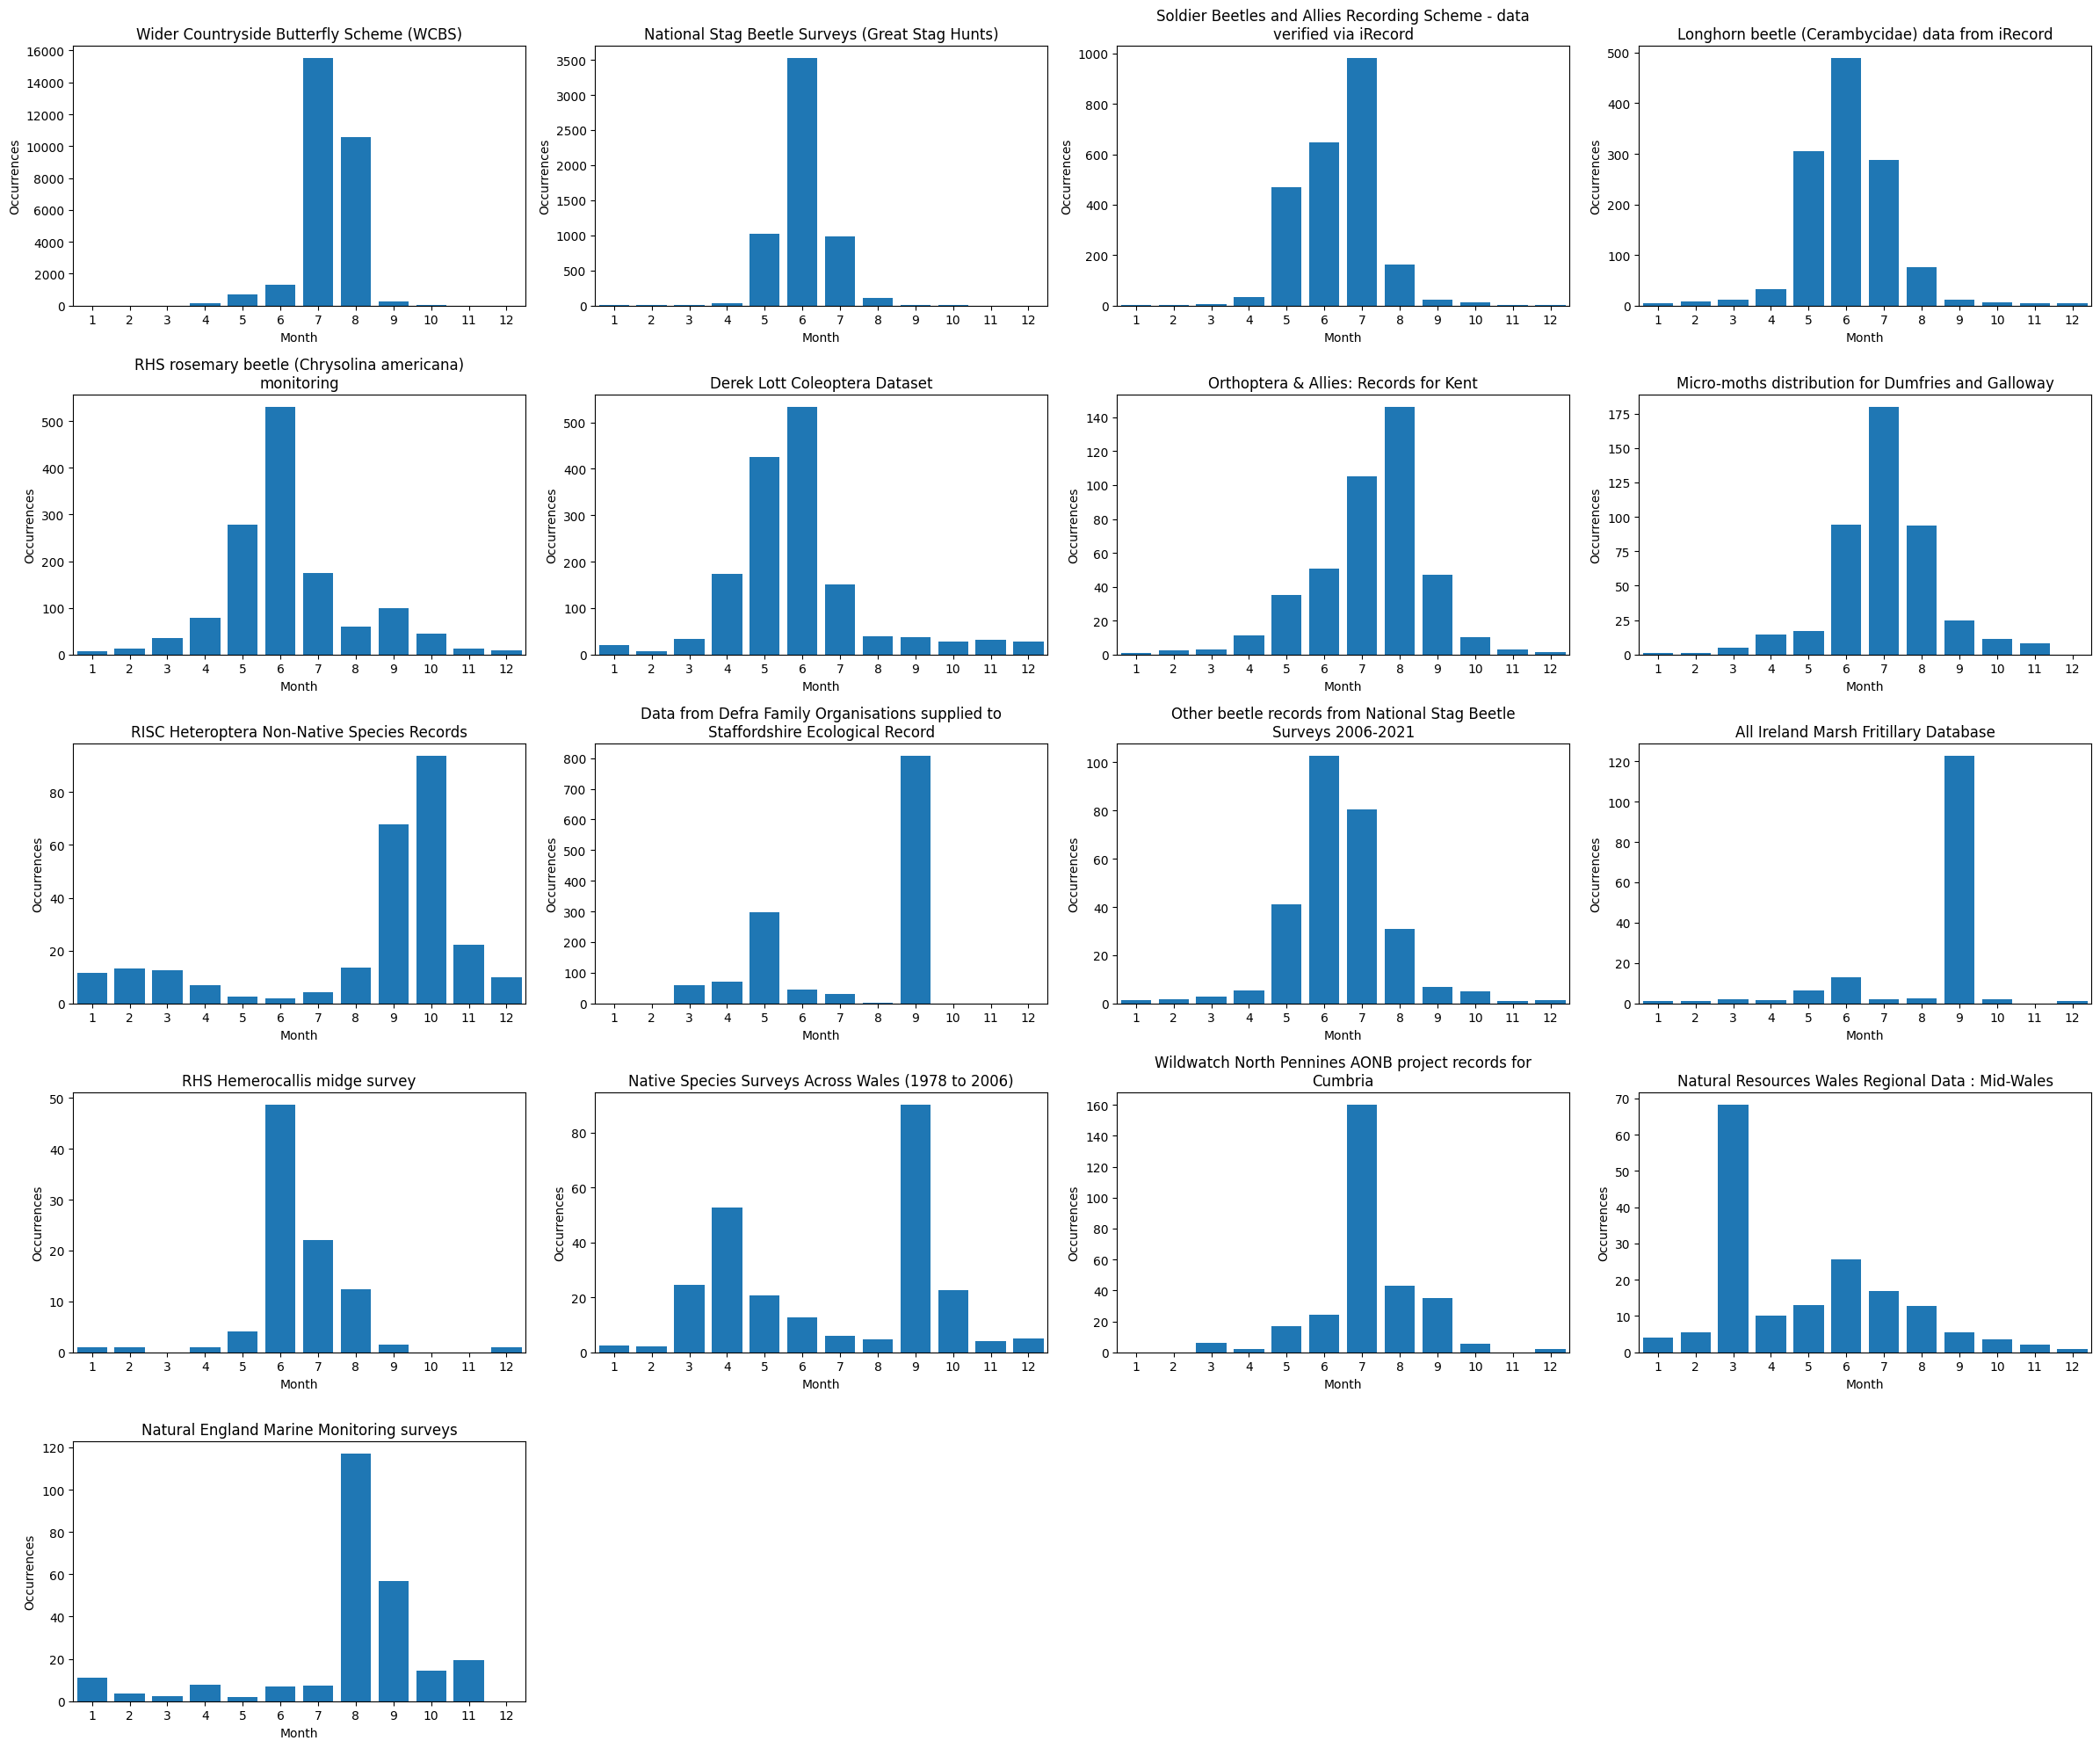

In [64]:
keys = high_strength_df['datasetKey'].tolist()
n = len(keys)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

axes = axes.flatten()

for i, key in enumerate(keys):
    df_month_subset = df_month[df_month['datasetKey'] == key]
    axes[i].bar(df_month_subset["month"], df_month_subset["occurrenceCount"])
    wrapped_title = "\n".join(textwrap.wrap(dataset_title_lookup.get(key, key), width=50))
    axes[i].set_title(wrapped_title)
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Occurrences")
    axes[i].set_xlim(0.5, 12.5)
    axes[i].set_xticks(range(1, 13)) 
    
# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Each dataset is plotted individually, showing its mean occurrences per month.
Axes are aligned, and titles wrapped for readability.

##### Observations

* **Species-specific datasets**: High seasonality is typical for datasets focused on a **single species or narrow taxonomic group**.
    * **Wider Countryside Butterfly Scheme (WCBS)**: Peaks in July–August, reflecting butterfly adult emergence and visibility during summer.
    * **National Stag Beetle Surveys (Great Stag Hunts)**: Peaks in June, coinciding with the beetle’s emergence for mating.
    * **All Ireland Marsh Fritillary Database**: Peak in September, similar seasonal emergence pattern as other butterflies.
    * **RISC Heteroptera Non-Native Species Records**: Peaks in October, likely reflecting species adapted to a different seasonal cycle.
    * **Natural England Marine Monitoring surveys**: Unusual distribution, likely due to marine survey timing and life cycles of marine insects.
    * **Other single-species datasets**: Tend to follow similar sharp seasonal peaks or offsets, reflecting species-specific activity periods.
* **Anomalous spikes**: Some datasets have unexpected peaks in certain months, often due to survey constraints or one-off events.

##### Conclusion
High-seasonality datasets indicate that **seasonal patterns are primarily driven by biological cycles** of the organisms being recorded rather than by sampling bias. 

#### Low-Seasonality Datasets

These datasets fall in the **bottom 5% of seasonality strength**, meaning their monthly occurrences are either **extremely concentrated in a single month** or show no **significant seasonal variation**.

In [65]:
low_strength_df = seasonality_df[seasonality_df["seasonalityStrength"] < seasonality_df["seasonalityStrength"].quantile(0.05)]
low_strength_df

datasetKey  seasonalityStrength  peakShare  \
115  68de8fdd-f30a-4d88-8eb0-27ebad6d96f8             0.000000   1.000000   
122  4f272892-7a07-434f-8a69-7032826bcfb3             0.000000   1.000000   
125  d6cd327a-7911-48e5-93e5-8664cb8a4ea8             0.000000   1.000000   
126  cf8107e1-68be-4c76-a71d-05d96aeea4cb             0.000000   1.000000   
133  229f2a59-4286-416a-838e-1069ef71bfbc             0.000000   1.000000   
154  41c3ea59-4cba-4708-bb9d-2b5ad9a402e7             0.000000   1.000000   
235  844b5647-f5d8-48b3-a900-1b50aea2d13f             0.000000   1.000000   
245  56a5cb72-db94-42f5-9f71-de81e56588b7             0.475610   0.426829   
246  c2722072-2464-41d0-b82e-adb4ef553550             0.266979   0.566745   
269  bd5b2544-6a60-4c1b-b153-c1cc0220eb3f             0.000000   1.000000   
276  71c21f25-c877-495b-a372-07c3a1c091ca             0.000000   1.000000   
280  7cb4a425-3aab-440e-8df2-7f0ef9b17ed4             0.040404   0.510101   
288  fe17fe38-29d7-48ec-a4f6-bda16a39679f             0.230415   0.557604   
292  7bf578b3-5753-4c11-bde0-4370fddf2ce9             0.000000   1.000000   
296  5108c281-71ad-4ad5-bbd8-160272dcd784             0.000000   1.000000   
305  becd96c5-e731-4636-8b29-97f8f2fe7ed3             0.000000   1.000000   
307  1ee2f194-4c11-4212-a77a-28a4cfcd5c50             0.000000   1.000000   

                                           datasetName  count  \
115        Dipterists Forum: Field Week 2022 (Norfolk)   8274   
122          Dipterists Forum: Field Week 2018 (Stoke)   7407   
125      Dipterists Forum: Field Week 2017 (Snowdonia)   6804   
126     Dipterists Forum: Field Week 2016 (Canterbury)   6435   
133       Dipterists Forum: Field Week 2019 (Stirling)   5627   
154  Dipterists Forum: Field Week 2015 (Nottinghams...   3711   
235  SNH Invertebrate Site Condition Monitoring 201...    501   
245  SNH Invertebrate Site Condition Monitoring 201...    428   
246  SNH Invertebrate Site Condition Monitoring 201...    427   
269  SNH Invertebrate Site Condition Monitoring 201...    261   
276                           MoJ BioBlitz August 2018    231   
280  SNH Invertebrate Site Condition Monitoring 201...    198   
288  SNH Invertebrate Site Condition Monitoring 201...    169   
292     Temporal variation in pesticide biodegradation    153   
296  SNH Invertebrate Site Condition Monitoring 201...    146   
305  SNH Invertebrate Site Condition Monitoring 201...    128   
307  SNH Invertebrate Site Condition Monitoring 201...    127   

                                           label  
115  68de8fdd-f30a-4d88-8eb0-27ebad6d96f8 (8274)  
122  4f272892-7a07-434f-8a69-7032826bcfb3 (7407)  
125  d6cd327a-7911-48e5-93e5-8664cb8a4ea8 (6804)  
126  cf8107e1-68be-4c76-a71d-05d96aeea4cb (6435)  
133  229f2a59-4286-416a-838e-1069ef71bfbc (5627)  
154  41c3ea59-4cba-4708-bb9d-2b5ad9a402e7 (3711)  
235   844b5647-f5d8-48b3-a900-1b50aea2d13f (501)  
245   56a5cb72-db94-42f5-9f71-de81e56588b7 (428)  
246   c2722072-2464-41d0-b82e-adb4ef553550 (427)  
269   bd5b2544-6a60-4c1b-b153-c1cc0220eb3f (261)  
276   71c21f25-c877-495b-a372-07c3a1c091ca (231)  
280   7cb4a425-3aab-440e-8df2-7f0ef9b17ed4 (198)  
288   fe17fe38-29d7-48ec-a4f6-bda16a39679f (169)  
292   7bf578b3-5753-4c11-bde0-4370fddf2ce9 (153)  
296   5108c281-71ad-4ad5-bbd8-160272dcd784 (146)  
305   becd96c5-e731-4636-8b29-97f8f2fe7ed3 (128)  
307   1ee2f194-4c11-4212-a77a-28a4cfcd5c50 (127)

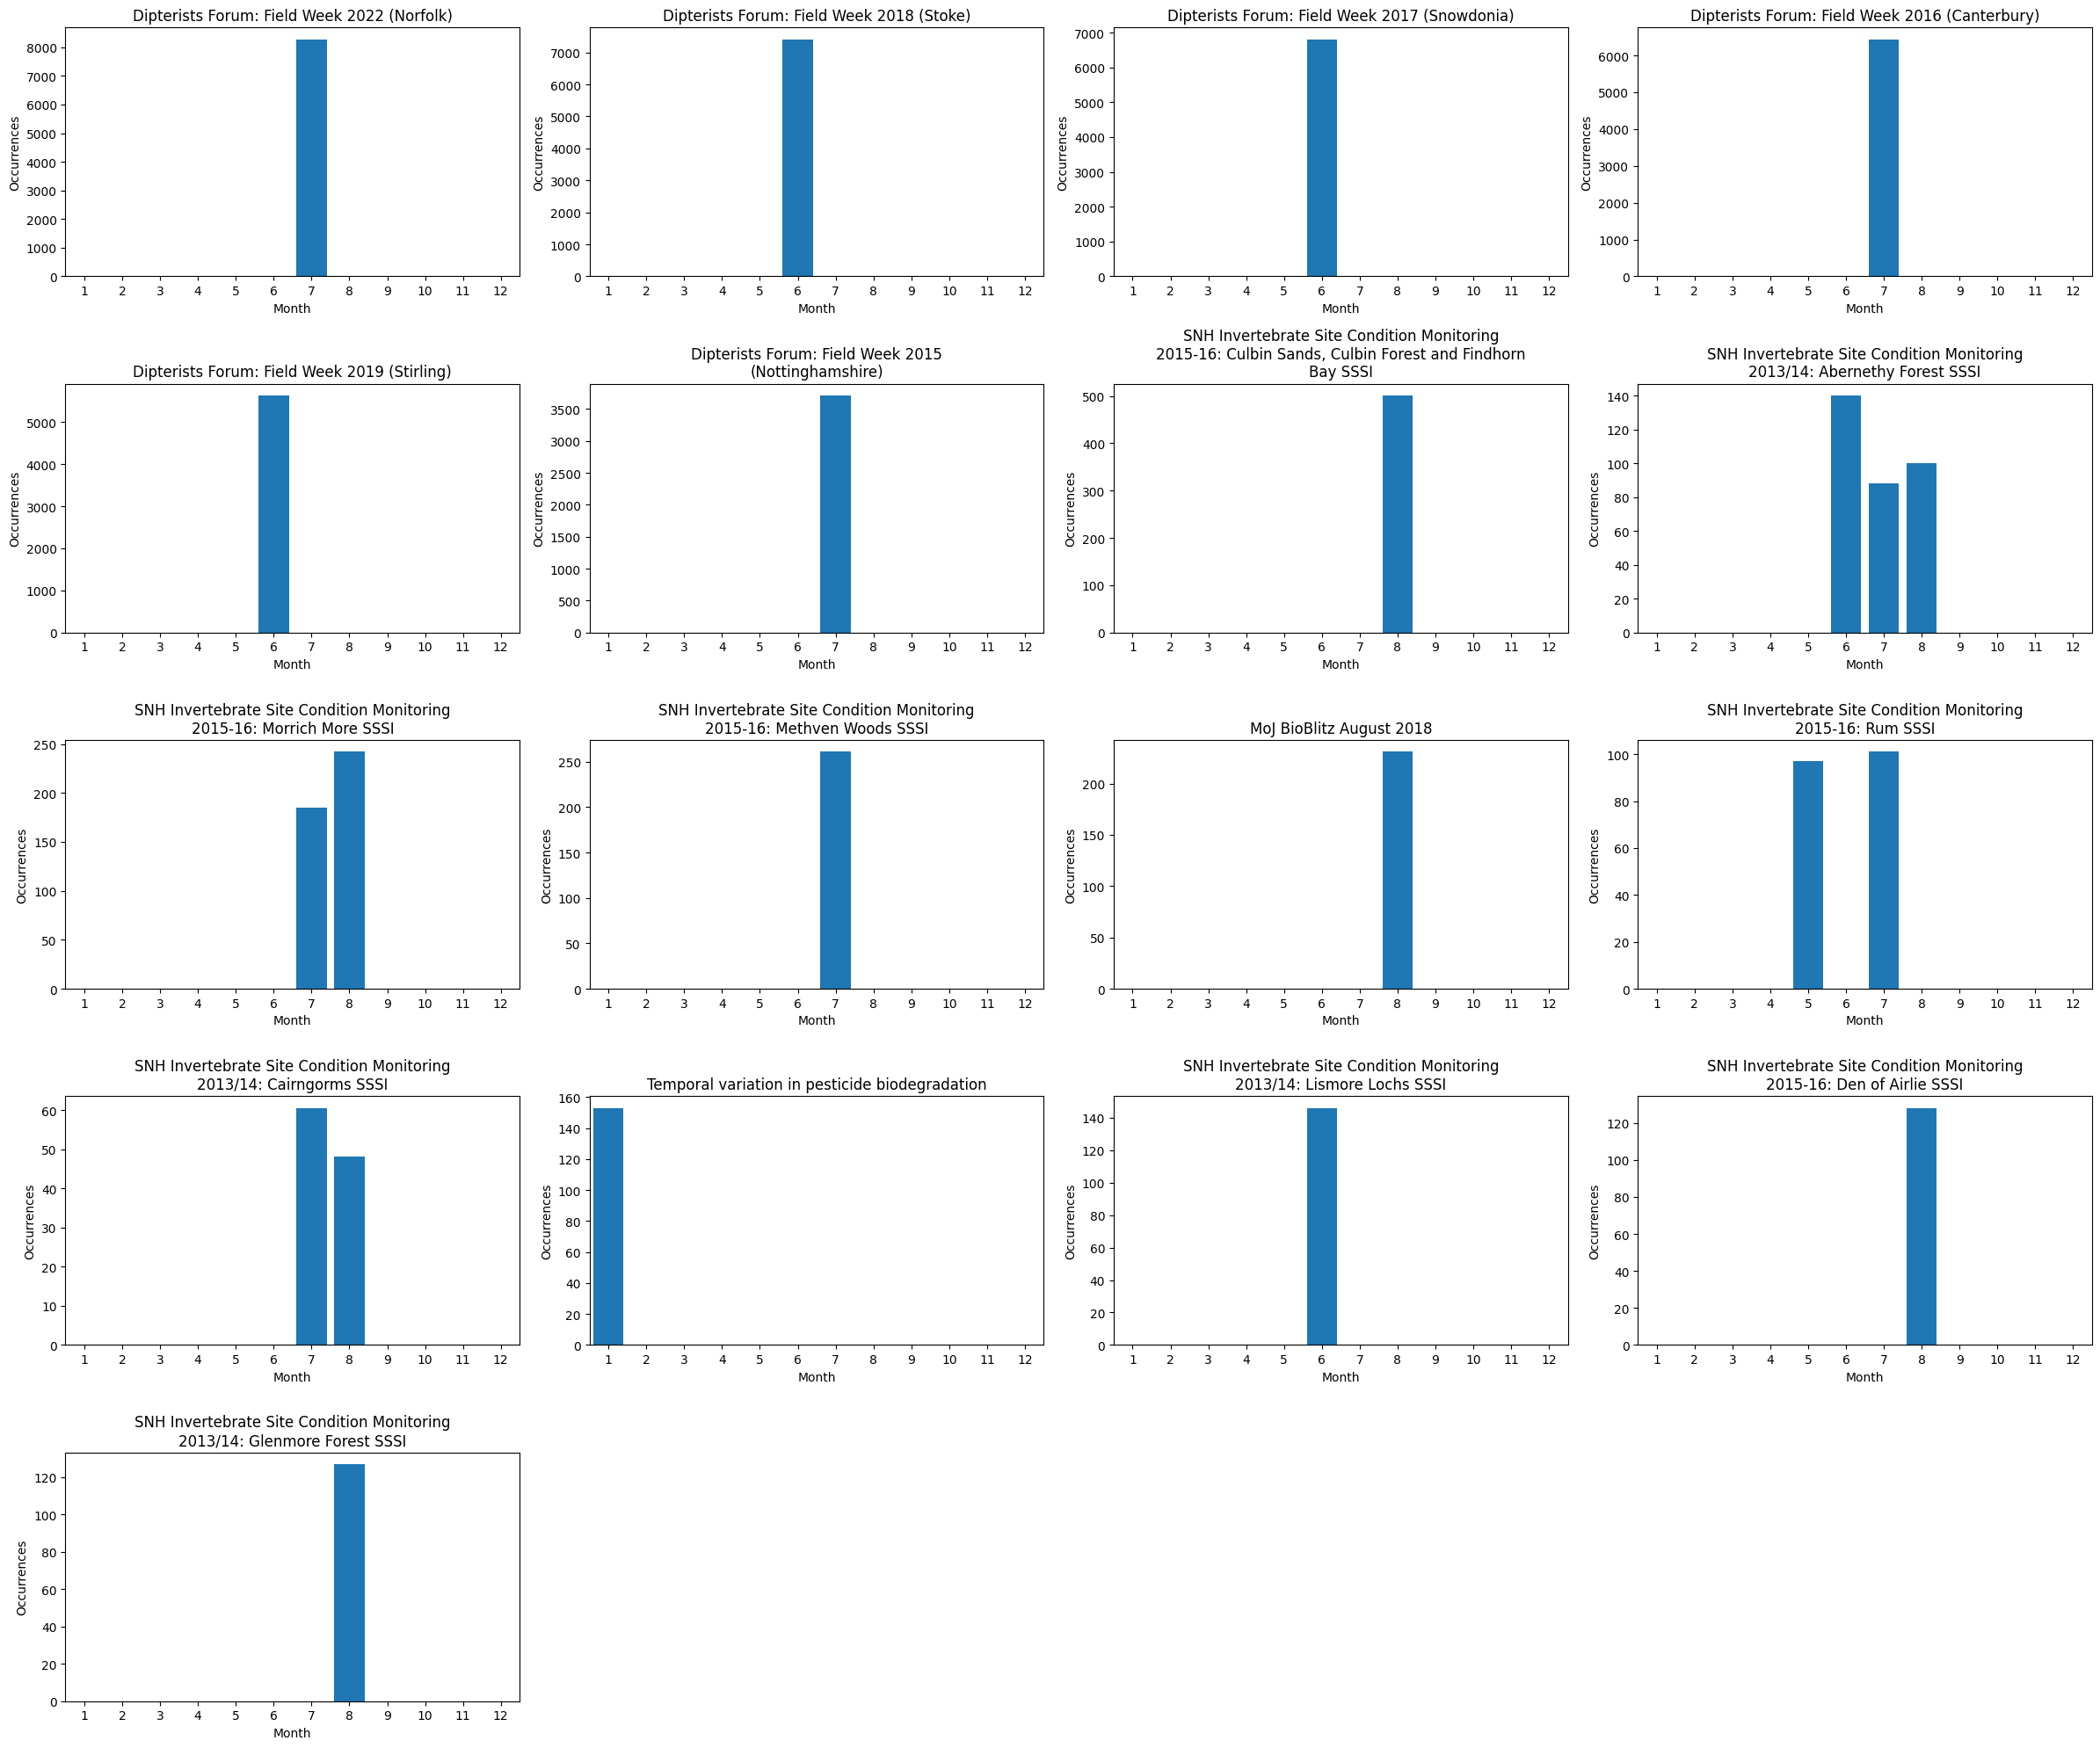

In [66]:
keys = low_strength_df['datasetKey'].tolist()
n = len(keys)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

axes = axes.flatten()

for i, key in enumerate(keys):
    df_month_subset = df_month[df_month['datasetKey'] == key]
    axes[i].bar(df_month_subset["month"], df_month_subset["occurrenceCount"])
    wrapped_title = "\n".join(textwrap.wrap(dataset_title_lookup.get(key, key), width=50))
    axes[i].set_title(wrapped_title)
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Occurrences")
    axes[i].set_xlim(0.5, 12.5)
    axes[i].set_xticks(range(1, 13)) 

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Each dataset is plotted individually to show monthly occurrence counts.
Most datasets display occurrences in only one or two months.

##### Observations
* **Single-event datasets**: Many datasets correspond to one-off events, e.g., *“MoJ BioBlitz August 2018”*, which naturally record observations in only one month.
* **Dipterist field weeks**: Several datasets (e.g., *Dipterists Forum: Field Week 2016–2022*) are restricted to **June or July**, reflecting the narrow collection window for Diptera species.
* **Small datasets**: Most low-strength datasets have very few records overall, which amplifies the concentration effect.

##### Conclusion
Low-seasonality datasets are generally **small, single-event, or short-collection-period datasets**. Their lack of seasonal spread contrasts sharply with high-seasonality datasets, which often capture species with extended or predictable seasonal activity.

#### High-Peak Datasets

High-peak datasets have a **very high proportion of occurrences concentrated in a single month**, even if the overall seasonality strength is not extreme. Essentially, most observations are recorded during one “peak” month.

In [67]:
high_peak = seasonality_df[seasonality_df["peakShare"] > seasonality_df["peakShare"].quantile(0.95)]
high_peak

datasetKey  seasonalityStrength  peakShare  \
115  68de8fdd-f30a-4d88-8eb0-27ebad6d96f8             0.000000   1.000000   
122  4f272892-7a07-434f-8a69-7032826bcfb3             0.000000   1.000000   
125  d6cd327a-7911-48e5-93e5-8664cb8a4ea8             0.000000   1.000000   
126  cf8107e1-68be-4c76-a71d-05d96aeea4cb             0.000000   1.000000   
133  229f2a59-4286-416a-838e-1069ef71bfbc             0.000000   1.000000   
154  41c3ea59-4cba-4708-bb9d-2b5ad9a402e7             0.000000   1.000000   
199  85e38c14-c3d4-4f16-b1dc-5cf0f5b601c8             1.986183   0.996546   
215  80576d53-992a-41f3-a3e3-dfd0fa0242ee             1.953488   0.988372   
235  844b5647-f5d8-48b3-a900-1b50aea2d13f             0.000000   1.000000   
240  6fa3cf71-7867-4143-adb3-0729df995932             2.913333   0.980000   
269  bd5b2544-6a60-4c1b-b153-c1cc0220eb3f             0.000000   1.000000   
271  96193ea2-f762-11e1-a439-00145eb45e9a             1.840637   0.960159   
276  71c21f25-c877-495b-a372-07c3a1c091ca             0.000000   1.000000   
292  7bf578b3-5753-4c11-bde0-4370fddf2ce9             0.000000   1.000000   
296  5108c281-71ad-4ad5-bbd8-160272dcd784             0.000000   1.000000   
305  becd96c5-e731-4636-8b29-97f8f2fe7ed3             0.000000   1.000000   
307  1ee2f194-4c11-4212-a77a-28a4cfcd5c50             0.000000   1.000000   

                                           datasetName  count  \
115        Dipterists Forum: Field Week 2022 (Norfolk)   8274   
122          Dipterists Forum: Field Week 2018 (Stoke)   7407   
125      Dipterists Forum: Field Week 2017 (Snowdonia)   6804   
126     Dipterists Forum: Field Week 2016 (Canterbury)   6435   
133       Dipterists Forum: Field Week 2019 (Stirling)   5627   
154  Dipterists Forum: Field Week 2015 (Nottinghams...   3711   
199      Dipterists Forum: Field Week 2002 (Inverness)   1158   
215                                 Ireland's BioBlitz    768   
235  SNH Invertebrate Site Condition Monitoring 201...    501   
240  Insects and other arthropods collected and/or ...    450   
269  SNH Invertebrate Site Condition Monitoring 201...    261   
271             Texas A&M University Insect Collection    251   
276                           MoJ BioBlitz August 2018    231   
292     Temporal variation in pesticide biodegradation    153   
296  SNH Invertebrate Site Condition Monitoring 201...    146   
305  SNH Invertebrate Site Condition Monitoring 201...    128   
307  SNH Invertebrate Site Condition Monitoring 201...    127   

                                           label  
115  68de8fdd-f30a-4d88-8eb0-27ebad6d96f8 (8274)  
122  4f272892-7a07-434f-8a69-7032826bcfb3 (7407)  
125  d6cd327a-7911-48e5-93e5-8664cb8a4ea8 (6804)  
126  cf8107e1-68be-4c76-a71d-05d96aeea4cb (6435)  
133  229f2a59-4286-416a-838e-1069ef71bfbc (5627)  
154  41c3ea59-4cba-4708-bb9d-2b5ad9a402e7 (3711)  
199  85e38c14-c3d4-4f16-b1dc-5cf0f5b601c8 (1158)  
215   80576d53-992a-41f3-a3e3-dfd0fa0242ee (768)  
235   844b5647-f5d8-48b3-a900-1b50aea2d13f (501)  
240   6fa3cf71-7867-4143-adb3-0729df995932 (450)  
269   bd5b2544-6a60-4c1b-b153-c1cc0220eb3f (261)  
271   96193ea2-f762-11e1-a439-00145eb45e9a (251)  
276   71c21f25-c877-495b-a372-07c3a1c091ca (231)  
292   7bf578b3-5753-4c11-bde0-4370fddf2ce9 (153)  
296   5108c281-71ad-4ad5-bbd8-160272dcd784 (146)  
305   becd96c5-e731-4636-8b29-97f8f2fe7ed3 (128)  
307   1ee2f194-4c11-4212-a77a-28a4cfcd5c50 (127)

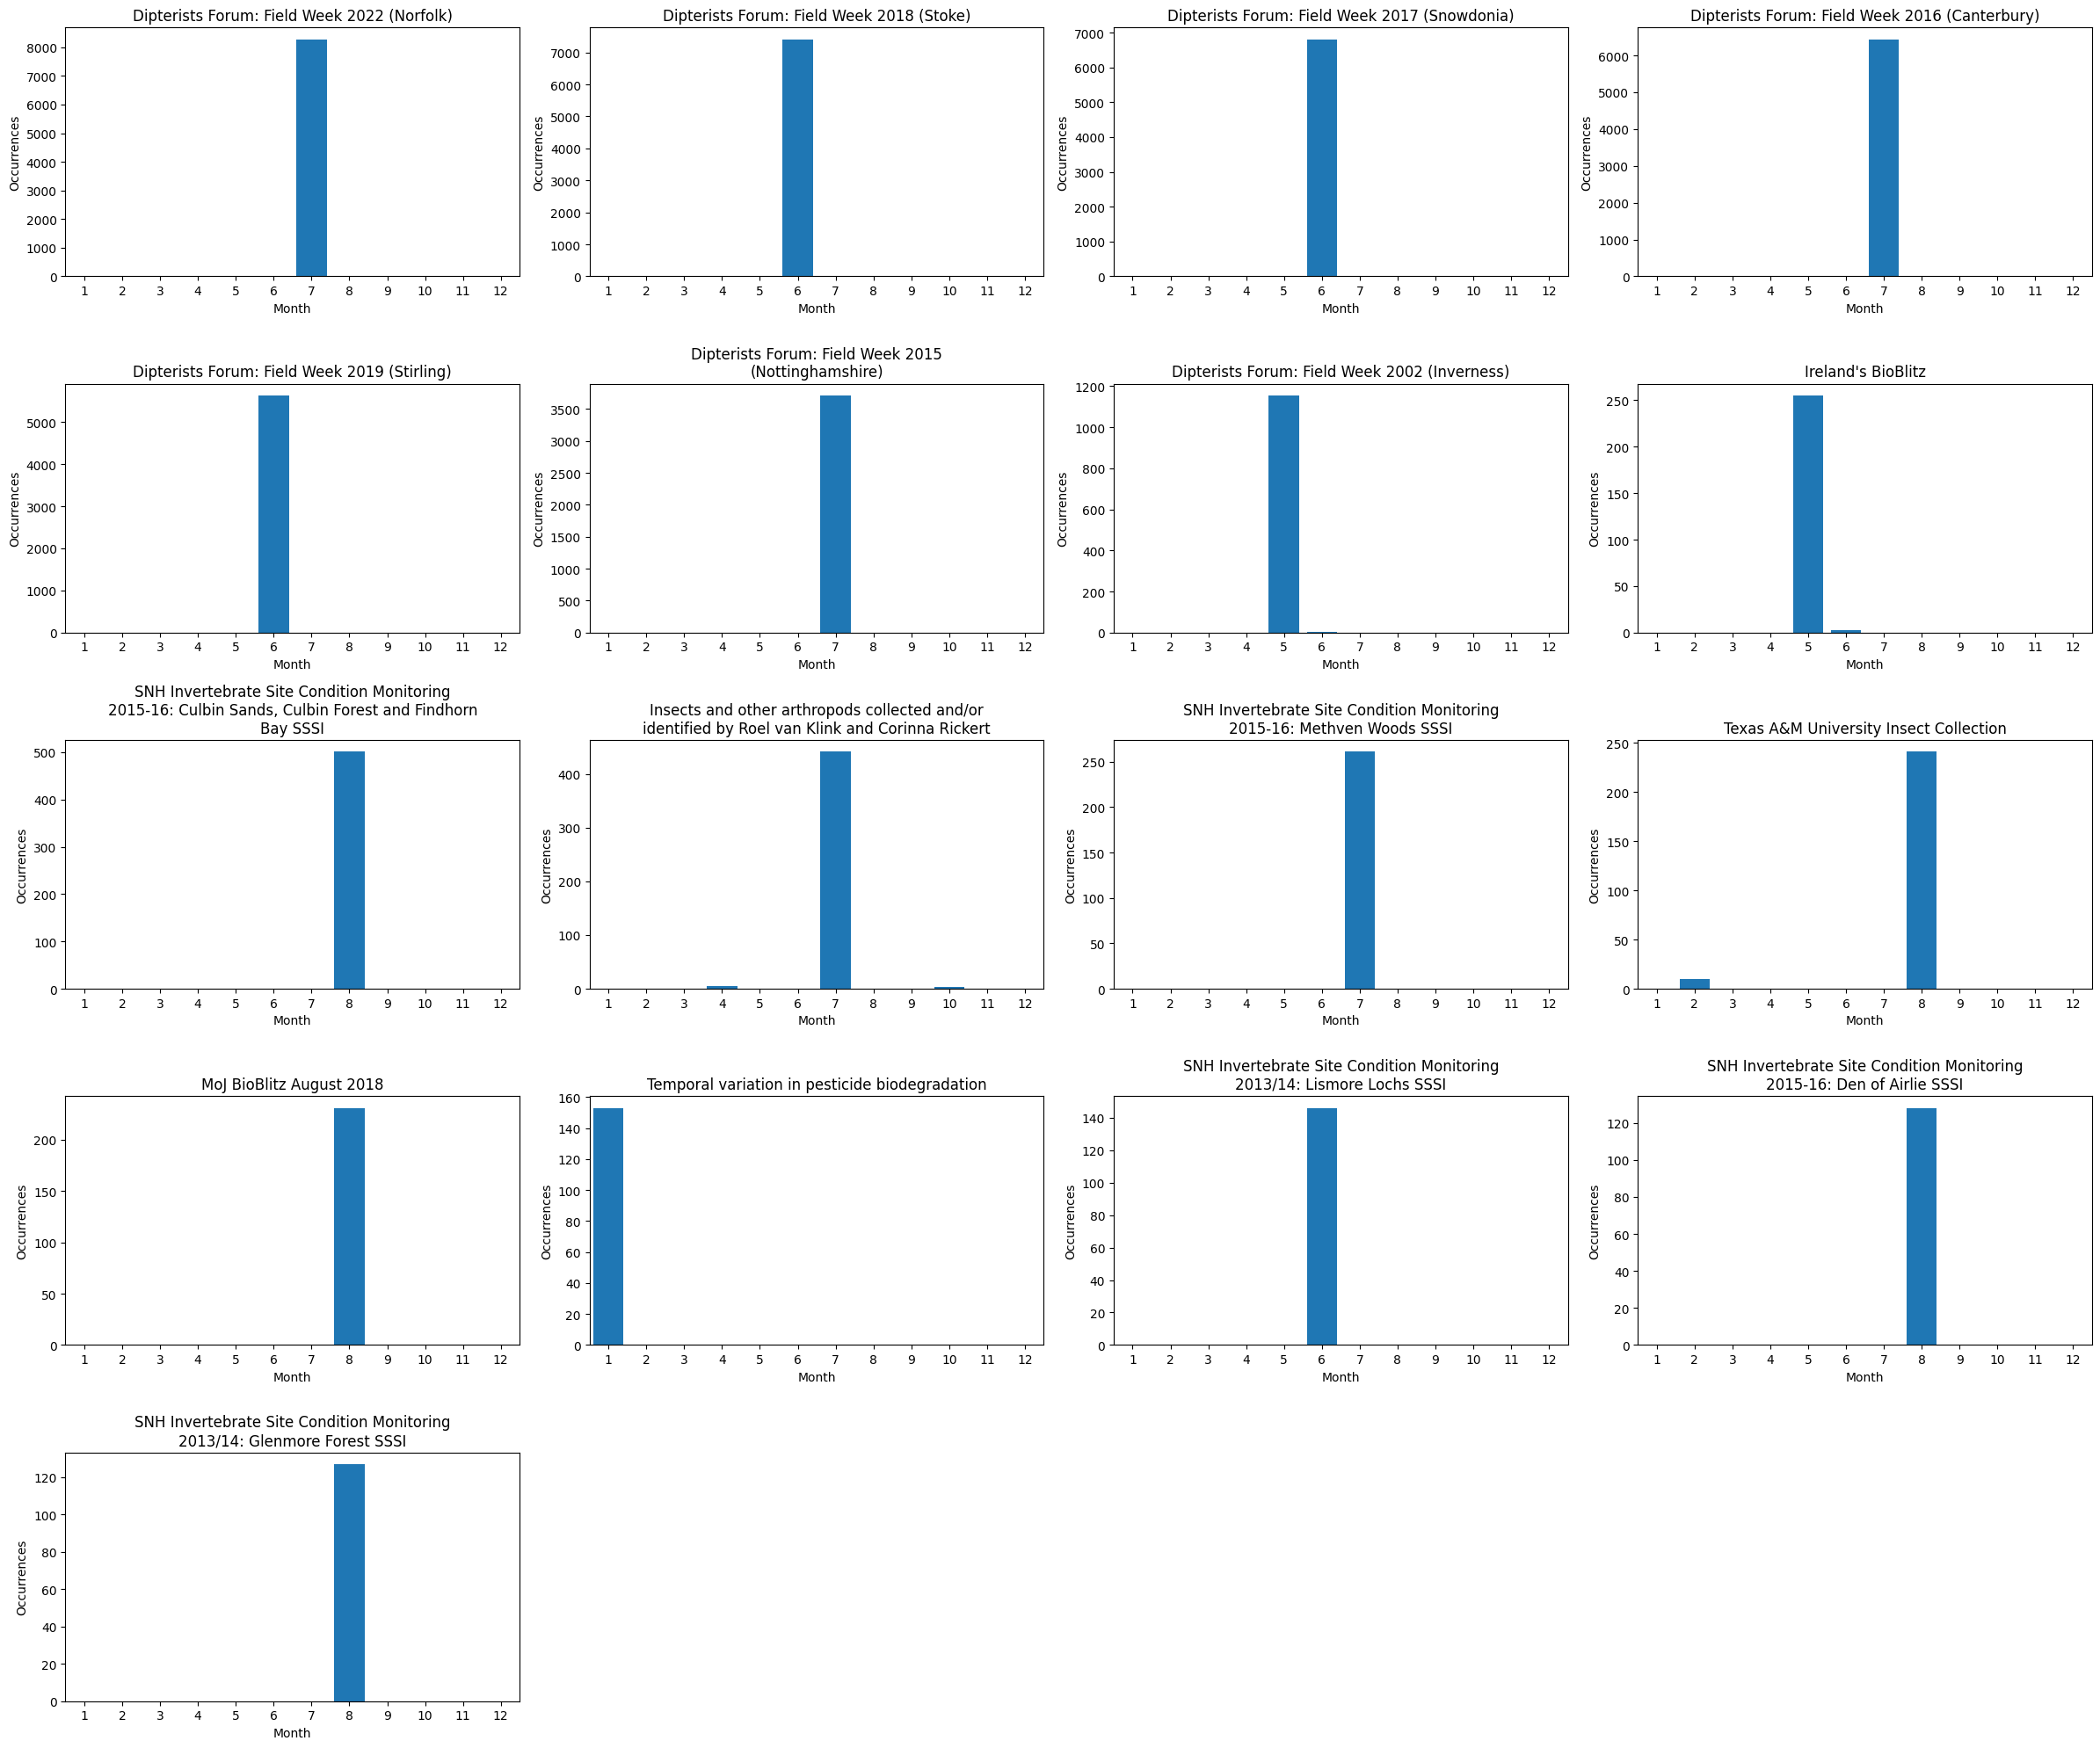

In [68]:
keys = high_peak['datasetKey'].tolist()
n = len(keys)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

axes = axes.flatten()

for i, key in enumerate(keys):
    df_month_subset = df_month[df_month['datasetKey'] == key]
    axes[i].bar(df_month_subset["month"], df_month_subset["occurrenceCount"])
    wrapped_title = "\n".join(textwrap.wrap(dataset_title_lookup.get(key, key), width=50))
    axes[i].set_title(wrapped_title)
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Occurrences")
    axes[i].set_xlim(0.5, 12.5)
    axes[i].set_xticks(range(1, 13)) 

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Each dataset is plotted by month.
Most high-peak datasets show one dominant month where nearly all occurrences happen, with the other months nearly empty.

##### Observations
* **Similarity to low-seasonality datasets**: High-peak datasets are often **small or single-event collections**, where data naturally clusters in one month.
* **Dipterist field weeks and BioBlitzes**: Many of these datasets are from short-term events, e.g., *“Dipterists Forum Field Week”* or *“Ireland’s BioBlitz”*, resulting in a single-month peak.
* **Small dataset sizes**: High-peak datasets tend to have relatively few total records, which amplifies the proportion in the peak month.

##### Conclusion
High-peak datasets reflect **methodological collection effects** rather than biological seasonality. They are concentrated in a single month due to event-based sampling or short survey periods, similar to low-seasonality datasets, but measured via **peak concentration rather than overall seasonal spread**.

#### Low-Peak Datasets

Low-peak datasets are those where **no single month dominates the observations**, i.e., the occurrences are fairly evenly distributed across months. They typically have a **flatter distribution**, even if there is some seasonal variation.

In [69]:
low_peak = seasonality_df[seasonality_df["peakShare"] < seasonality_df["peakShare"].quantile(0.05)]
low_peak

datasetKey  seasonalityStrength  peakShare  \
19   b4c0c858-f6f3-415f-aec1-f7e3534a8126             1.644732   0.156561   
38   68fa8801-0b3e-400e-afa6-5ad08e0f1e4c             1.577570   0.147791   
52   559204c2-814a-4756-92b5-9dec6f0a1936             1.505314   0.141474   
62   4f174243-a6e2-4ab3-99cb-129d2a6267e7             1.501042   0.131197   
81   da5f7bf0-c72a-4087-b116-885fbdd10c03             1.731103   0.149388   
102  af445805-7681-42d8-92a3-7b37693606e9             1.759329   0.153333   
132  80455677-4c00-4c3d-8290-446e459a9e9c             1.750256   0.156772   
135  5e096c60-f909-4213-9cf3-05b1f2ad5a5e             1.420727   0.157859   
139  d57e08b7-391c-44fd-bdcd-0694f7e223a3             1.724076   0.162352   
166  def5f1ab-0299-4f17-8dce-5ad153cc3969             0.669700   0.107285   
207  821765c9-59dc-4310-9970-d82c2eb9eff7             1.265936   0.128226   
214  f9e117d8-d8f7-4d62-b0e2-c12c78f08c56             1.375716   0.142815   
233  90eae6b8-57d2-4d24-8eb3-1dbde00f1669             1.604845   0.159115   
255  9261d82a-1247-41e4-b40c-4724577137ac             1.052203   0.146139   
259  cc9ae2eb-b6e9-4a4e-80ec-13c21e49963f             0.923565   0.131480   
268  b8866a8d-adc7-4a3a-887b-e59f830bb988             1.111433   0.135070   
313  4d06d9c0-3c7b-4570-bc7c-35ce74120959             1.023812   0.161156   

                                           datasetName   count  \
19                UK Ladybird Survey data from iRecord  261495   
38                           Ladybird Survey of the UK   84227   
52                      Bob Merritt Coleoptera Dataset   61184   
62       Water Beetle Surveys from Britain and Ireland   41731   
81      Bob Merritt invertebrate records for VCs 72-75   24679   
102  Water Bug (Aquatic Heteroptera) data for Brita...   11918   
132   Water Bug (aquatic Heteroptera) data for Britain    5837   
135  Heleomyzid Recording Scheme - data verified vi...    5379   
139  Stonefly (Plecoptera) records from Britain and...    5128   
166  Siphonaptera and Phthiraptera Recording Scheme...    2242   
207  Survey and monitoring records for Scottish Wil...     994   
214                               Ladybirds of Ireland     776   
233                     NRW Regional Data: North Wales     510   
255           SEWBReC Other Insects (South East Wales)     364   
259  Kelp Fly Recording Scheme - records verified v...     339   
268  INNS records held by BIS in Powys and Brecon B...     271   
313                       DBRC Trichoptera 1974 - 2015     115   

                                             label  
19   b4c0c858-f6f3-415f-aec1-f7e3534a8126 (261495)  
38    68fa8801-0b3e-400e-afa6-5ad08e0f1e4c (84227)  
52    559204c2-814a-4756-92b5-9dec6f0a1936 (61184)  
62    4f174243-a6e2-4ab3-99cb-129d2a6267e7 (41731)  
81    da5f7bf0-c72a-4087-b116-885fbdd10c03 (24679)  
102   af445805-7681-42d8-92a3-7b37693606e9 (11918)  
132    80455677-4c00-4c3d-8290-446e459a9e9c (5837)  
135    5e096c60-f909-4213-9cf3-05b1f2ad5a5e (5379)  
139    d57e08b7-391c-44fd-bdcd-0694f7e223a3 (5128)  
166    def5f1ab-0299-4f17-8dce-5ad153cc3969 (2242)  
207     821765c9-59dc-4310-9970-d82c2eb9eff7 (994)  
214     f9e117d8-d8f7-4d62-b0e2-c12c78f08c56 (776)  
233     90eae6b8-57d2-4d24-8eb3-1dbde00f1669 (510)  
255     9261d82a-1247-41e4-b40c-4724577137ac (364)  
259     cc9ae2eb-b6e9-4a4e-80ec-13c21e49963f (339)  
268     b8866a8d-adc7-4a3a-887b-e59f830bb988 (271)  
313     4d06d9c0-3c7b-4570-bc7c-35ce74120959 (115)

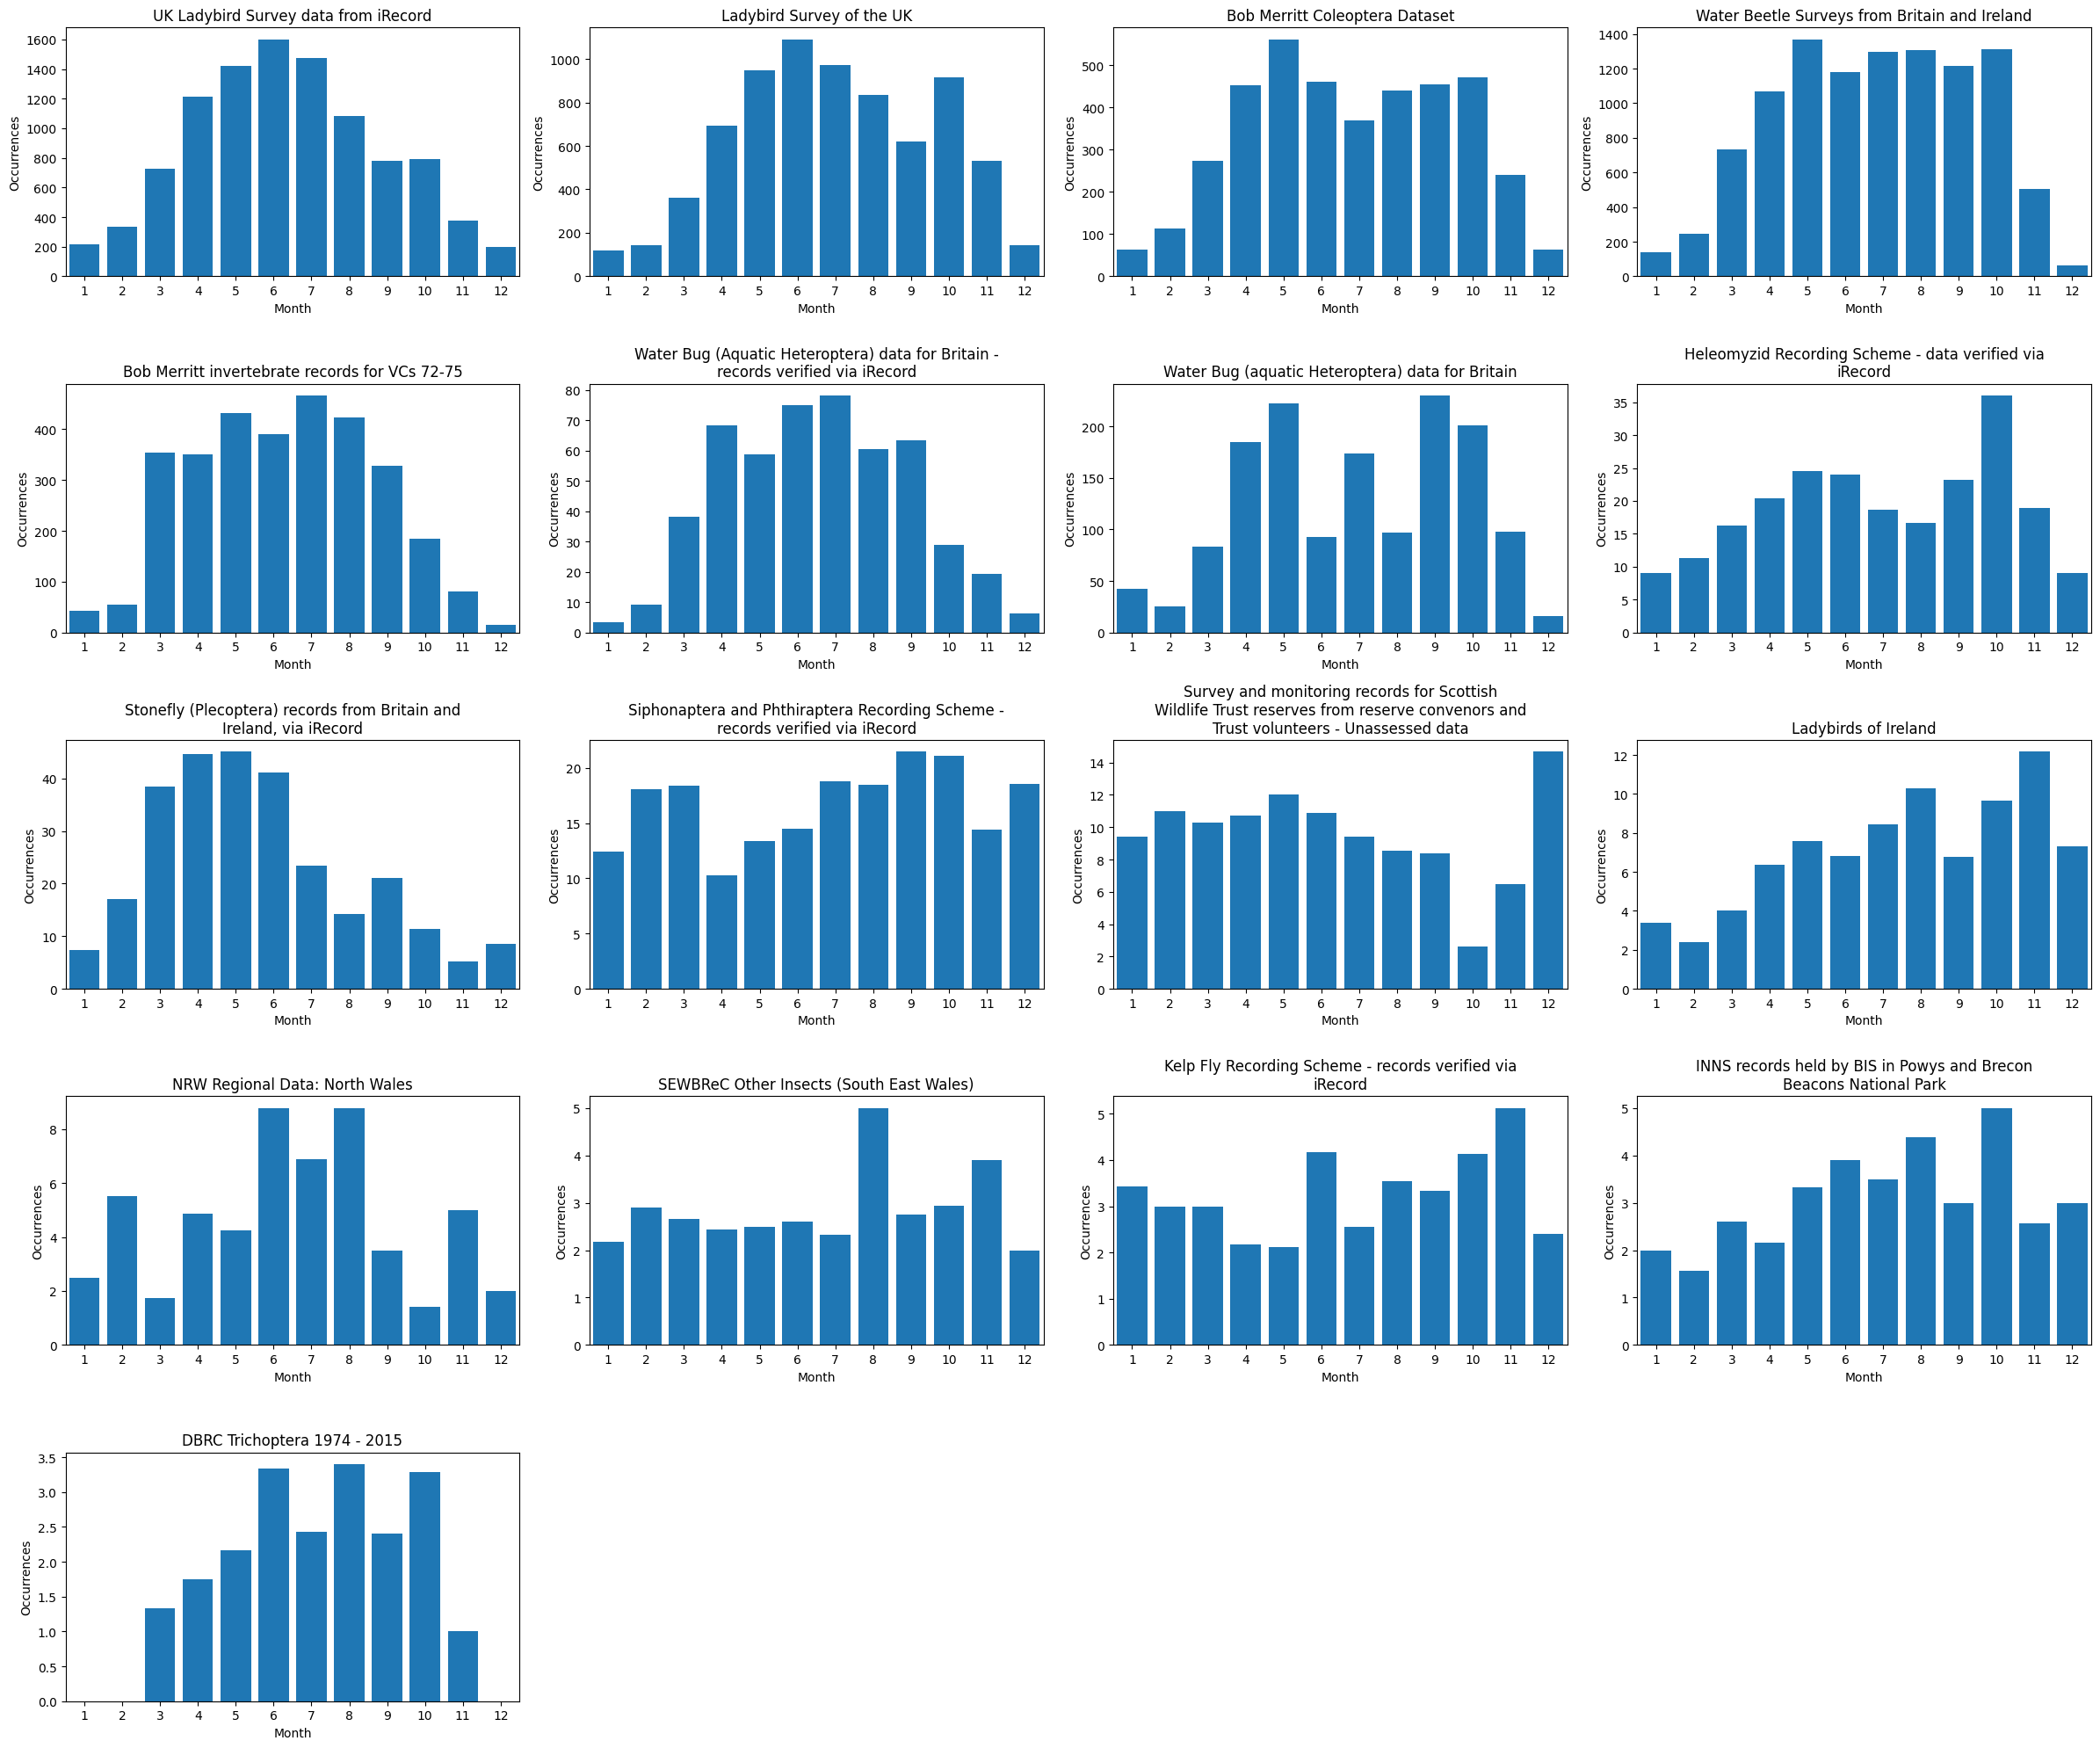

In [70]:
keys = low_peak['datasetKey'].tolist()
n = len(keys)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

axes = axes.flatten()

for i, key in enumerate(keys):
    df_month_subset = df_month[df_month['datasetKey'] == key]
    axes[i].bar(df_month_subset["month"], df_month_subset["occurrenceCount"])
    wrapped_title = "\n".join(textwrap.wrap(dataset_title_lookup.get(key, key), width=50))
    axes[i].set_title(wrapped_title)
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Occurrences")
    axes[i].set_xlim(0.5, 12.5)
    axes[i].set_xticks(range(1, 13)) 

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

Low peak datasets have a normal looking distribution, despite being flatter, they are mostly single species datasets, relating to beetles, namely ladybirds and water bugs. The low peak datasets that are flat are very small. 

Each dataset is plotted by month.
The distributions appear relatively flat, with no single month having a very large proportion of occurrences.

##### Observations
* **Mostly single-species datasets**: Many relate to beetles—particularly ladybirds and water bugs. These datasets typically cover the species’ full active season, giving a relatively even distribution.
* **Flat but small datasets**: The datasets with very low peak share are often small, which can make distributions appear less “spiky” than larger datasets with concentrated sampling.
* **Normal-looking distributions**: Despite being low-peak, most datasets still roughly follow a bell-shaped or uniform seasonal pattern, rather than having extreme spikes.

##### Conclusion
Low-peak datasets represent **species or surveys with observations spread across many months**, often small-scale single-species surveys. They contrast with high-peak datasets where most observations are concentrated in one month.

### Charting Seasonality by Year

To visualize **how the monthly distribution of occurrences changes year by year**, relative to the overall dataset distribution, and identify anomalies.

##### Data Preperation

In [71]:
df_month = df[df['activePost2019'] == True]
df_month = df_month.drop(columns=['datasetKey', 'speciesRichness', 'date', 'tier', 'activePost2019'])
df_month = df_month.groupby(['year', 'month']).agg("mean").reset_index()

* Only includes datasets **active post-2019**.
* Aggregates occurrences **by year and month**.

##### Visualization Logic
For each year:
* Calculate monthly occurrence proportions.
* Compare each year against the overall monthly distribution.
* Highlight:
    * increase → months with higher proportion than baseline.
    * decrease → months with lower proportion than baseline.

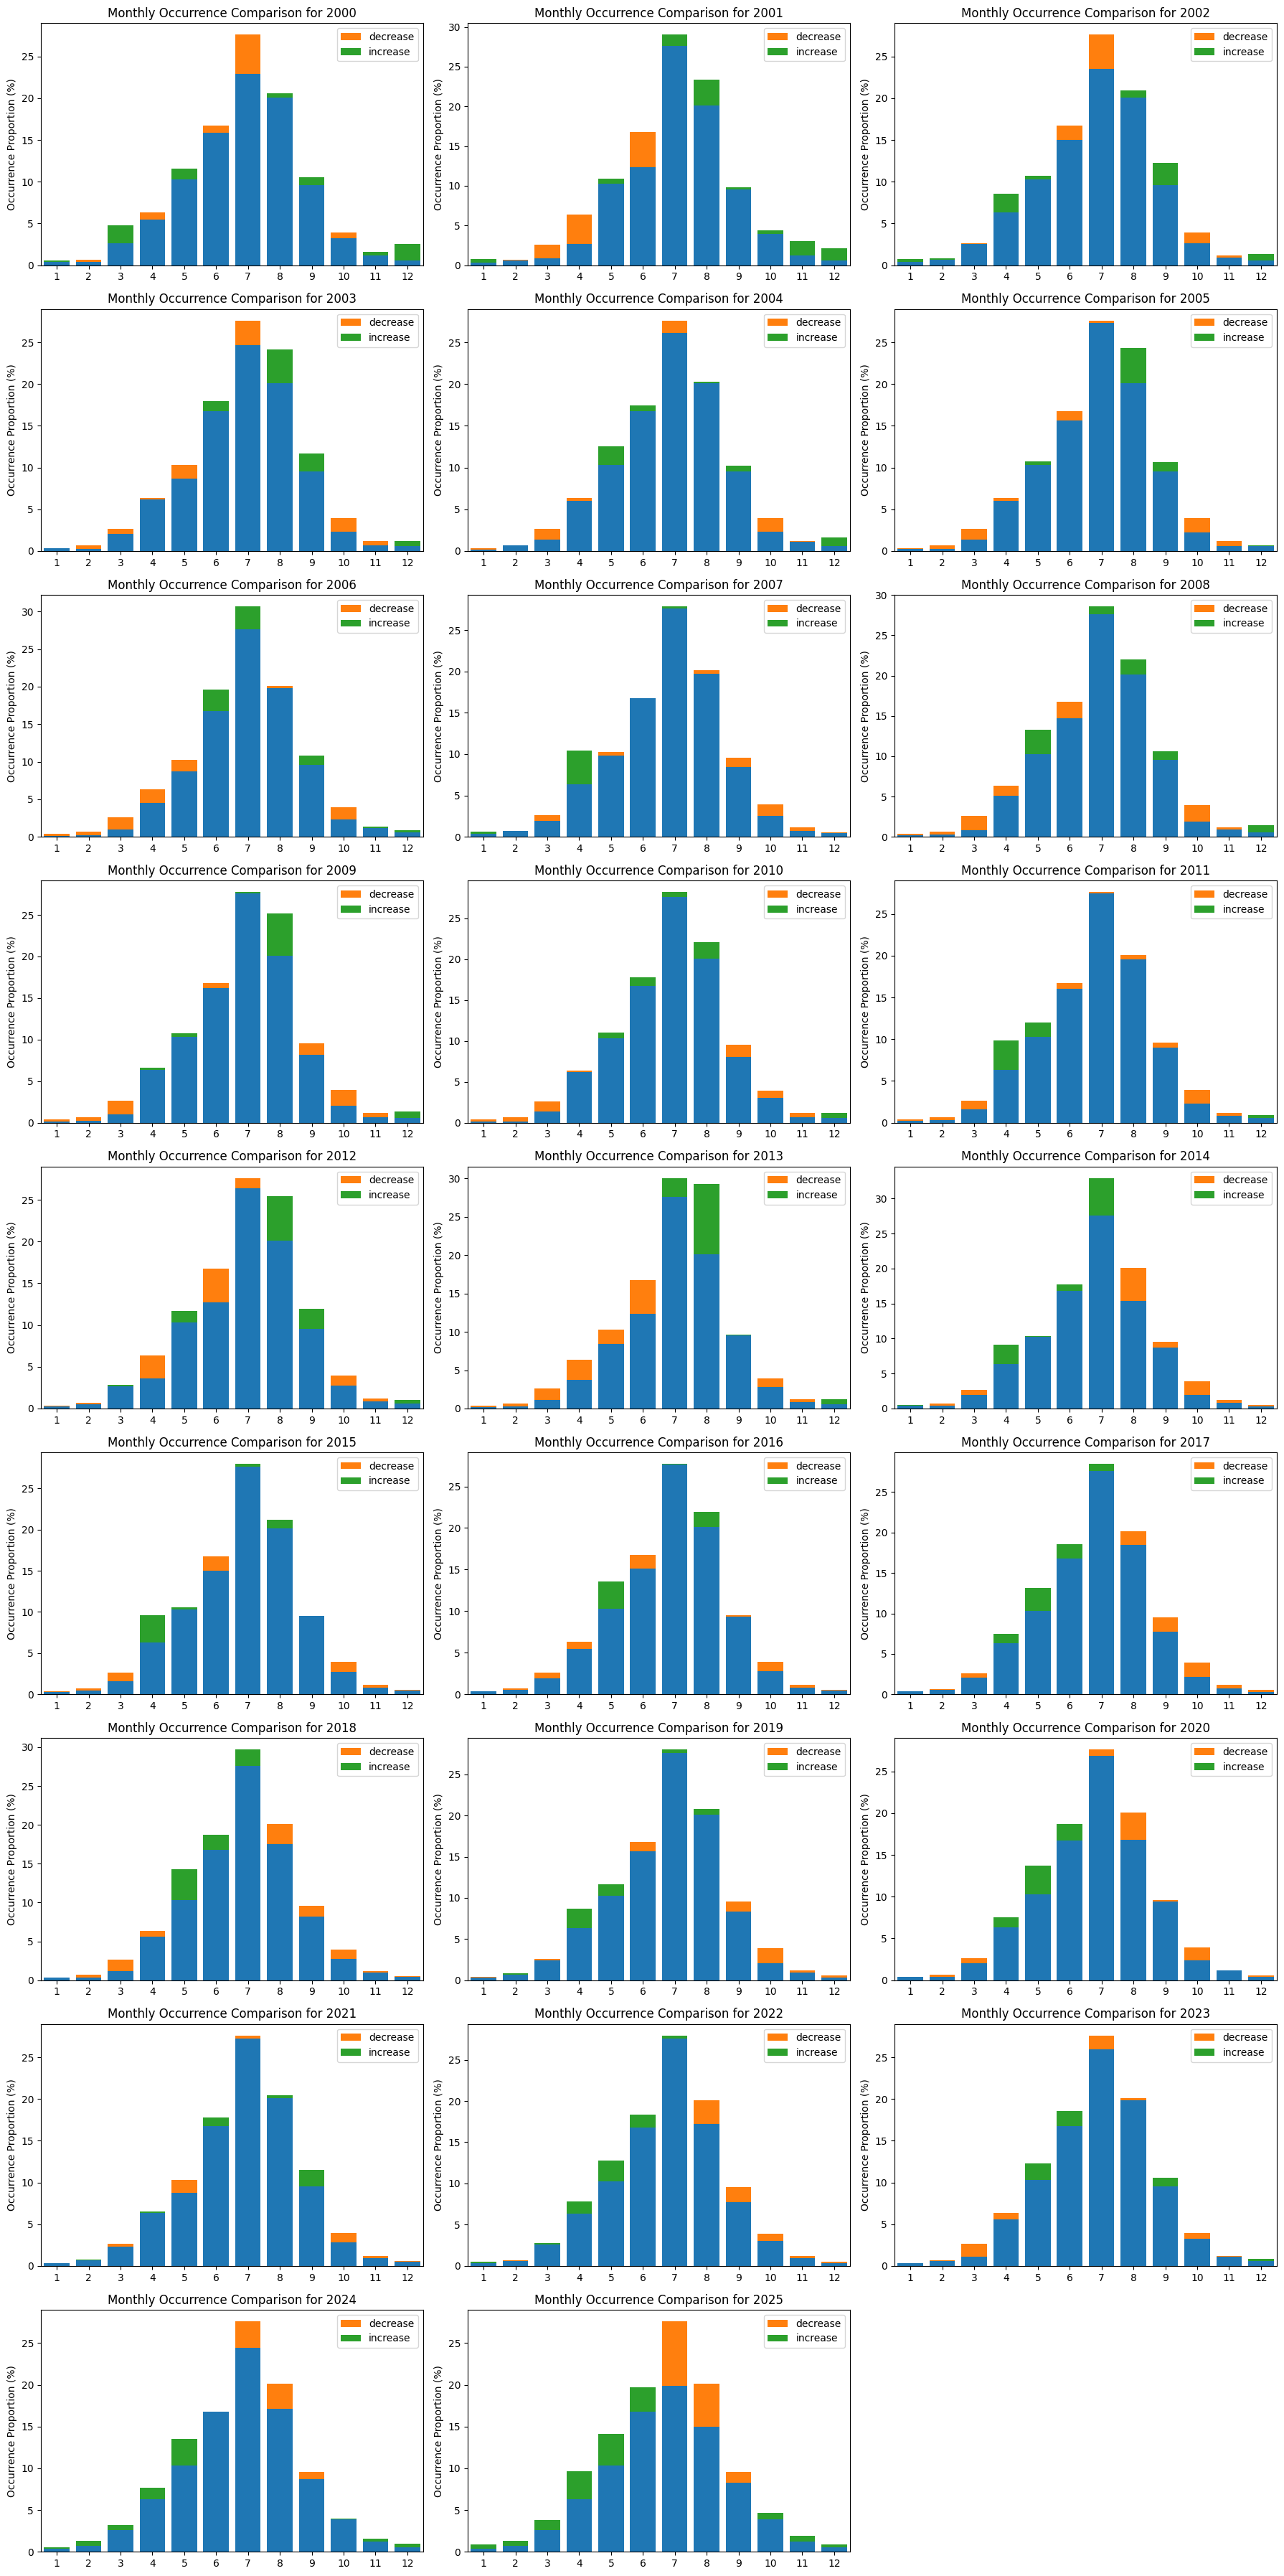

In [72]:
years = df_month['year'].unique().tolist()
n = len(years)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

axes = axes.flatten()

df_seasonality = df.drop(columns = ['datasetKey', 'year', 'speciesRichness', 'date', 'tier', 'activePost2019'])
df_seasonality = df_seasonality.groupby(['month']).agg("mean").reset_index()
df_seasonality['occurrenceProportion'] = (df_seasonality['occurrenceCount'] * 100) / df_seasonality['occurrenceCount'].sum()

for i, year in enumerate(years):
    subset_seasonality = df_month[df_month['year'] == year].copy().drop(columns = ['year'])
    subset_seasonality['occurrenceProportion'] = (subset_seasonality['occurrenceCount'] * 100) / subset_seasonality['occurrenceCount'].sum()

    baseline = df_seasonality.set_index('month')["occurrenceProportion"]
    comparison = subset_seasonality.set_index('month')["occurrenceProportion"]
    combined = (pd.concat([baseline, comparison], axis=1).rename(columns={"occurrenceProportion": "baseline", 0: "comparison"}))
    combined.columns = ["baseline", "comparison"]
    combined["diff"] = combined["comparison"] - combined["baseline"]
    combined["increase"] = combined["diff"].clip(lower=0)
    combined["decrease"] = (-combined["diff"]).clip(lower=0)
    combined["baseline"] = combined["baseline"] - combined["decrease"]
    
    axes[i].bar(combined.index, combined["baseline"])
    axes[i].bar(combined.index, combined["decrease"], bottom=combined["baseline"], label="decrease")
    axes[i].bar(combined.index, combined["increase"], bottom=combined["baseline"], label="increase")
    axes[i].set_title(f"Monthly Occurrence Comparison for {str(year)}")
    axes[i].set_ylabel("Occurrence Proportion (%)")
    axes[i].set_xlim(0.5, 12.5)
    axes[i].set_xticks(range(1, 13)) 
    axes[i].legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

##### Observations
* Most years follow a similar seasonal pattern to the overall dataset:
    * July is consistently the peak month.
    * Minor fluctuations (June vs August, January vs February) are negligible.
* Notable deviations:
    * 2014, 2017, 2018, 2020, 2022, 2025: August lower than June.
    * 2001: January slightly higher than February (negligible due to low counts).
    * 2007: April higher than May → warrants closer inspection.
    * 2025: Flatter distribution → likely incomplete data; later months not yet published.

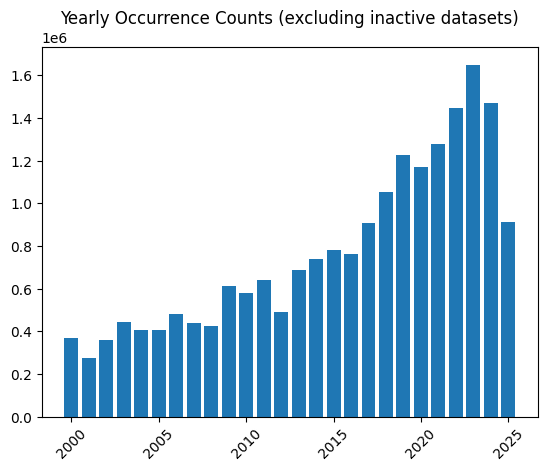

In [73]:
df_yearly_drop_inactive = df[(df["activePost2019"] == True)].groupby(["year"])["occurrenceCount"].sum().reset_index()
plt.bar(df_yearly_drop_inactive["year"], df_yearly_drop_inactive["occurrenceCount"])
plt.title("Yearly Occurrence Counts (excluding inactive datasets)")
plt.xticks(rotation=45)
plt.show()

##### Observation
* 2007 shows a slight drop in total occurrences → may explain unusual monthly distributions that year.
* Could mean sampling volatility is a cause for anomalies.

##### Conclusions
1. July is the main peak month across years.
2. Minor deviations in early or late months are likely due to:
    * Early warm springs (shifted seasonality).
    * Sampling effort variations.
3. 2025 should be excluded from temporal analysis due to incomplete data.
4. 2007 anomaly could reflect fewer observations rather than a real biological shift.

## Tier-based Seasonality

To understand how seasonal patterns vary according to **dataset abundance tiers**, which are defined based on total occurrence counts:
* Top1: Top 1% of datasets by total occurrences.
* Top10: Top 10% (excluding Top1).
* Bottom90: Remaining 90% of datasets.

##### Tier Assignment

In [74]:
dataset_tier_df = df.groupby('datasetKey')['occurrenceCount'].sum().reset_index().sort_values('occurrenceCount', ascending=False)
top_keys = list(dataset_tier_df['datasetKey'])

def get_tier(x):
    if x['datasetKey'] in top_keys[:len(top_keys)//100]:
        return ("Top1")
    elif x['datasetKey'] in top_keys[:len(top_keys)//10]:
        return ("Top10")
    else:
        return ("Bottom90")
        
dataset_tier_df['tier'] = dataset_tier_df.apply(get_tier, axis=1)
dataset_tier_df = dataset_tier_df.drop(columns=['occurrenceCount'])

In [75]:
# drop old tier column
df.drop(columns=['tier'], inplace=True)

df = df.merge(dataset_tier_df, on='datasetKey', how='left')
df.head()

datasetKey  year  month  speciesRichness  \
0  a69c6cda-5dc0-4362-88ed-b39d90eb4d17  2020      8              111   
1  a69c6cda-5dc0-4362-88ed-b39d90eb4d17  2022      5              162   
2  a69c6cda-5dc0-4362-88ed-b39d90eb4d17  2022      9               86   
3  a69c6cda-5dc0-4362-88ed-b39d90eb4d17  2013      4               23   
4  a69c6cda-5dc0-4362-88ed-b39d90eb4d17  2007      3                9   

   occurrenceCount       date  activePost2019   tier  
0             6298 2020-08-01            True  Top10  
1             6730 2022-05-01            True  Top10  
2             3857 2022-09-01            True  Top10  
3               81 2013-04-01            True  Top10  
4               26 2007-03-01            True  Top10

##### Aggregated Monthly Seasonality by Tier

In [76]:
df_month = df.groupby(["tier", "year", "month"]).agg(occurrenceCount=("occurrenceCount", "sum")).reset_index()
df_month = df_month.drop(columns=['year']).groupby(["tier", "month"]).mean().reset_index()

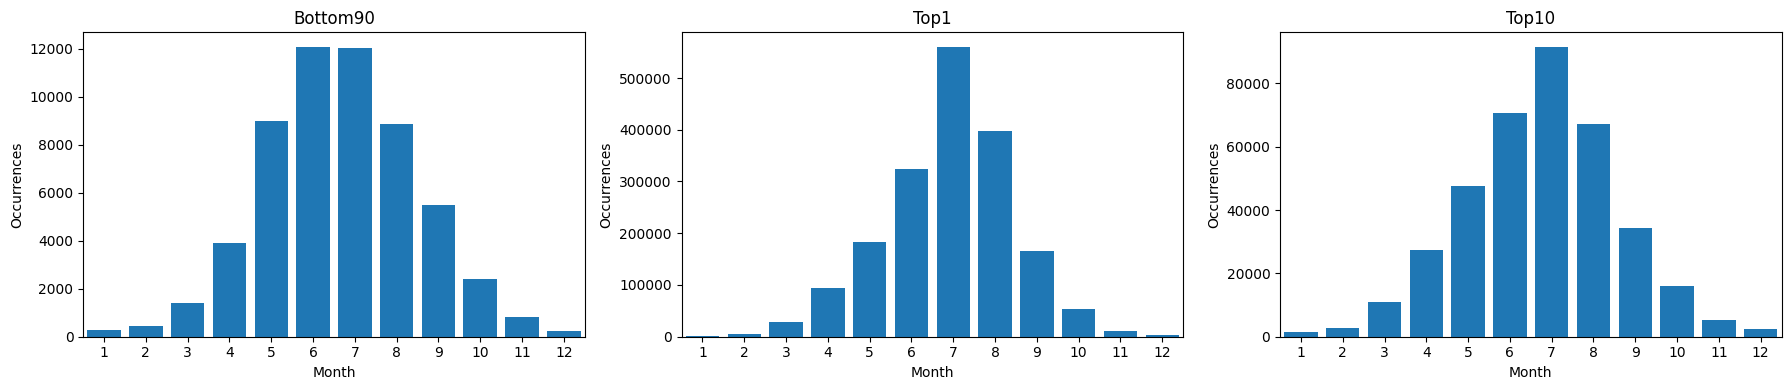

In [77]:
tiers = df_month['tier'].unique().tolist()
n = len(tiers)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

axes = axes.flatten()

for i, tier in enumerate(tiers):
    df_month_subset = df_month[df_month['tier'] == tier]
    axes[i].bar(df_month_subset["month"], df_month_subset["occurrenceCount"])
    axes[i].set_title(tier)
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Occurrences")
    axes[i].set_xlim(0.5, 12.5)
    axes[i].set_xticks(range(1, 13)) 

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

##### Observations
**Top 1% datasets**
* Strongly **peaked** distribution.
* July is the **dominant month**.
* Shape closely mirrors the **aggregate dataset distribution**.

**Top 10% datasets**
* Still **peaked**, but slightly less sharp
* July remains dominant, but month order differs slightly. **June > August**

**Bottom 90% datasets**
* **Flatter distribution**
* Peaks are less pronounced. 
* Month order differs. **June > July**, and **May > August**

##### Interpretation
* **Aggregate seasonal patterns are partially shaped by dataset concentration**:
    * A few very large datasets (Top 1%) dominate the signal.
    * Most smaller datasets (Bottom 90%) have flatter or noisier patterns, likely reflecting sampling variability rather than ecology.
* Peaks in **Top 1%/Top 10%** datasets are strong enough to **drive the July-dominant pattern** observed in the overall dataset.
* Bottom **90%** datasets contribute **less sharply to the seasonal signal**, showing that ecological conclusions should account for dataset weighting.

## Seasonal Inequality

### Plot Inequality Metrics by Month

To quantify how reporting concentration varies across months using four inequality metrics:
* **Top 1% share** – proportion of monthly occurrences contributed by the top 1% of datasets
* **Top 10% share** – proportion contributed by the top 10%
* **Gini coefficient** – distributional inequality across datasets
* **HHI (Herfindahl–Hirschman Index)** – concentration index (sum of squared shares)

In [78]:
results = []
for month in df['month'].unique():
    df_dataset = df[df['month'] == month].groupby(["datasetKey"])["occurrenceCount"].sum().reset_index()
    occurence_counts = df_dataset.sort_values(by='occurrenceCount', ascending=False)['occurrenceCount']
    top1_n = max(int(len(occurence_counts) * 0.01), 1)
    top10_n = max(int(len(occurence_counts) * 0.1), 1)
    top1_share = occurence_counts[:top1_n].sum() / occurence_counts.sum()
    top10_share = occurence_counts[:top10_n].sum() / occurence_counts.sum()
    x = np.sort(occurence_counts)
    n = len(x)
    cum = np.cumsum(x)
    gini = (n + 1 - 2 * (cum.sum() / cum[-1])) / n
    shares = occurence_counts / occurence_counts.sum()
    hhi = (shares ** 2).sum()
    results.append({'month': month, 'top1_share': top1_share, 'top10_share': top10_share, 'gini': gini, 'hhi': hhi})
df_inequality = pd.DataFrame(results).sort_values(by='month')

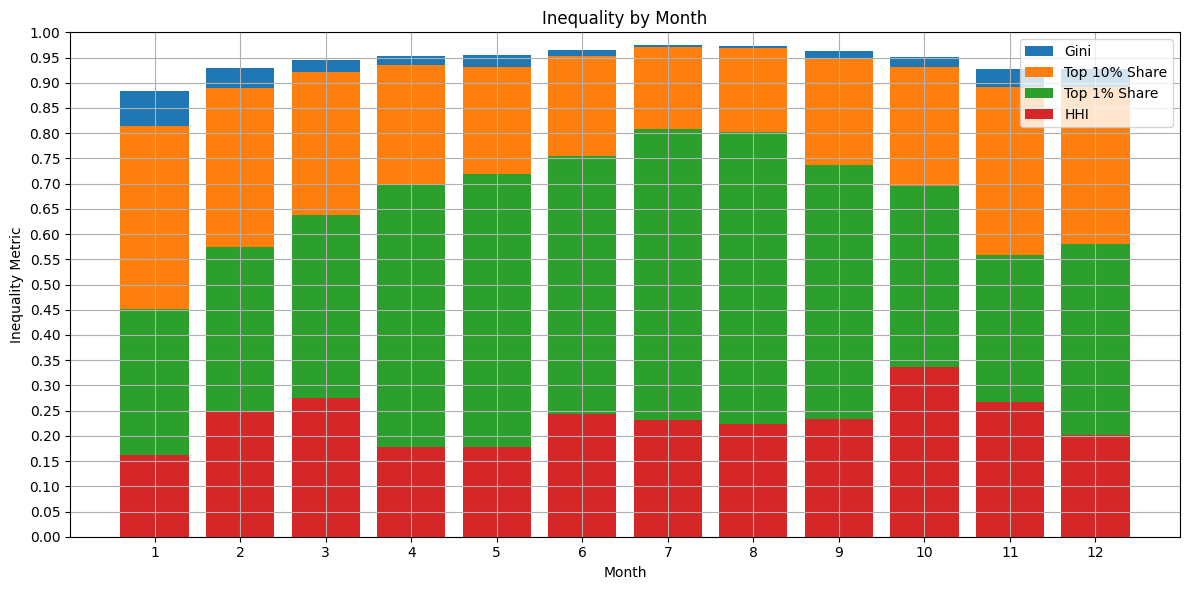

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df_inequality["month"], df_inequality["gini"], label="Gini")
ax.bar(df_inequality["month"], df_inequality["top10_share"], label="Top 10% Share")
ax.bar(df_inequality["month"], df_inequality["top1_share"], label="Top 1% Share")
ax.bar(df_inequality["month"], df_inequality["hhi"], label="HHI")
months = df_inequality["month"].unique()
ax.set_xticks(months)
ax.set_yticks(np.arange(0, 1.05, .05))
ax.tick_params(axis="x")
ax.set_ylim(0, 1)
ax.set_xlabel("Month")
ax.set_ylabel("Inequality Metric")
ax.set_title("Inequality by Month")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Inequality varies across months. Concentration measures increase from winter through spring, peaking in July and August. The Top 1% share rises from 45% in January to over 80% in July, indicating that peak-season activity is disproportionately driven by a small amount of dominant datasets.

This confirms that aggregate summer spikes reflect increased reporting activity and heightened centralisation within the datasets. Winter reporting is more distributed across datasets, suggesting that smaller contributors play a relatively larger role outside peak months.

##### Observations
Clear seasonal structure emerges:
* Concentration increases steadily from winter into summer.
* July and August exhibit the highest inequality.
* The Top 1% share rises from ~45% in January to >80% in July.
* Gini and HHI follow the same pattern, confirming that this is not an artefact of a single metric.

##### Interpretation
1. **Summer peak activity is highly centralised.** A very small number of dominant datasets drive most occurrences during peak season.
2. **Winter reporting is comparatively distributed.** Smaller datasets contribute proportionally more outside peak months.
3. The aggregate summer spike therefore reflects **both ecological seasonality and reporting concentration dynamics.**

This confirms that seasonality in the aggregate data is partially shaped by dataset dominance, not purely biological activity.

### Remove Inactive Dataset

To test whether historical dominance inflates concentration, datasets inactive post-2019 were removed.

In [80]:
df_drop_inactive = df[df['activePost2019'] == True]
results = []
for month in df_drop_inactive['month'].unique():
    df_dataset = df_drop_inactive[df_drop_inactive['month'] == month].groupby(["datasetKey"])["occurrenceCount"].sum().reset_index()
    occurence_counts = df_dataset.sort_values(by='occurrenceCount', ascending=False)['occurrenceCount']
    top1_n = max(int(len(occurence_counts) * 0.01), 1)
    top10_n = max(int(len(occurence_counts) * 0.1), 1)
    top1_share = occurence_counts[:top1_n].sum() / occurence_counts.sum()
    top10_share = occurence_counts[:top10_n].sum() / occurence_counts.sum()
    x = np.sort(occurence_counts)
    n = len(x)
    cum = np.cumsum(x)
    gini = (n + 1 - 2 * (cum.sum() / cum[-1])) / n
    shares = occurence_counts / occurence_counts.sum()
    hhi = (shares ** 2).sum()
    results.append({'month': month, 'top1_share': top1_share, 'top10_share': top10_share, 'gini': gini, 'hhi': hhi})
df_inequality = pd.DataFrame(results).sort_values(by='month')

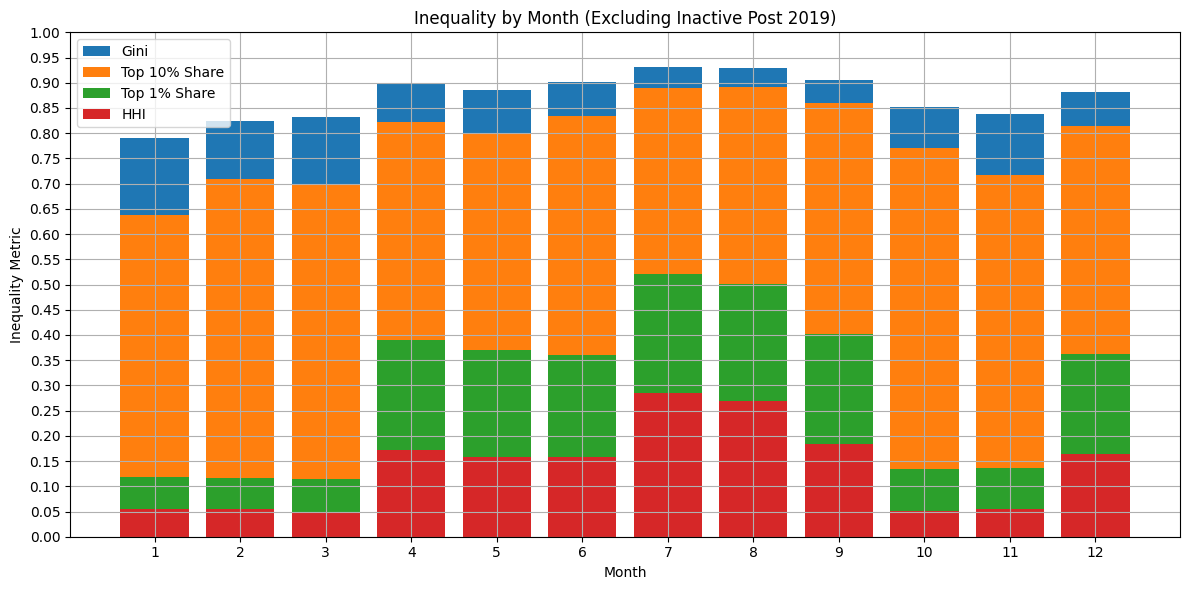

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df_inequality["month"], df_inequality["gini"], label="Gini")
ax.bar(df_inequality["month"], df_inequality["top10_share"], label="Top 10% Share")
ax.bar(df_inequality["month"], df_inequality["top1_share"], label="Top 1% Share")
ax.bar(df_inequality["month"], df_inequality["hhi"], label="HHI")
months = df_inequality["month"].unique()
ax.set_xticks(months)
ax.tick_params(axis="x")
ax.set_yticks(np.arange(0, 1.05, .05))
ax.set_ylim(0, 1)
ax.set_xlabel("Month")
ax.set_ylabel("Inequality Metric")
ax.set_title("Inequality by Month (Excluding Inactive Post 2019)")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

##### Observations
* Winter concentration collapses dramatically:
    * **Top 1% share ~12% in January–March**
* Summer concentration remains pronounced:
    * **Top 1% share ~52% in July**
* Gini and HHI still rise strongly from spring into summer.

##### Interpretation
1. **Winter inequality was historically inflated.** Previously dominant datasets that are now inactive contributed disproportionately to off-peak months.
2. **Summer centralisation persists structurally.** Even after removing inactive datasets, reporting during peak season remains heavily concentrated.
3. The magnitude of seasonal inequality decreases, but **the shape of the concentration curve remains intact**.

## Inequality Over Time

### Plot Inequality Metrics

To assess how reporting concentration evolved longitudinally, inequality metrics were computed annually:
* Top 1% share
* Top 10% share
* Gini coefficient
* HHI

In [82]:
results = []
for year in df['year'].unique():
    df_dataset = df[df['year'] == year].groupby(["datasetKey"])["occurrenceCount"].sum().reset_index()
    occurence_counts = df_dataset.sort_values(by='occurrenceCount', ascending=False)['occurrenceCount']
    top1_n = max(int(len(occurence_counts) * 0.01), 1)
    top10_n = max(int(len(occurence_counts) * 0.1), 1)
    top1_share = occurence_counts[:top1_n].sum() / occurence_counts.sum()
    top10_share = occurence_counts[:top10_n].sum() / occurence_counts.sum()
    x = np.sort(occurence_counts)
    n = len(x)
    cum = np.cumsum(x)
    gini = (n + 1 - 2 * (cum.sum() / cum[-1])) / n
    shares = occurence_counts / occurence_counts.sum()
    hhi = (shares ** 2).sum()
    results.append({'year': year, 'top1_share': top1_share, 'top10_share': top10_share, 'gini': gini, 'hhi': hhi})
df_inequality = pd.DataFrame(results).sort_values(by='year')

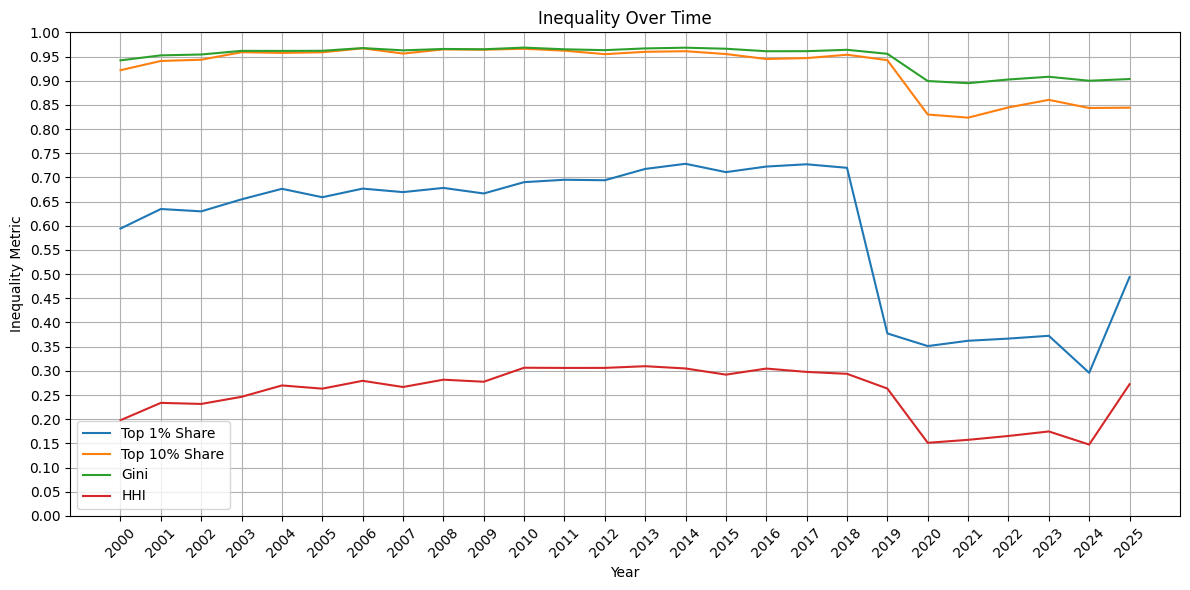

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_inequality["year"], df_inequality["top1_share"], label="Top 1% Share")
ax.plot(df_inequality["year"], df_inequality["top10_share"], label="Top 10% Share")
ax.plot(df_inequality["year"], df_inequality["gini"], label="Gini")
ax.plot(df_inequality["year"], df_inequality["hhi"], label="HHI")
years = df_inequality["year"].unique()
ax.set_xticks(years)
ax.set_yticks(np.arange(0, 1.05, .05))
ax.tick_params(axis="x", rotation=45)
ax.set_ylim(0, 1)
ax.set_xlabel("Year")
ax.set_ylabel("Inequality Metric")
ax.set_title("Inequality Over Time")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Between 2000 and 2018, concentration increases steadily across all metrics:
* Top 1% share rises from ~60% to ~75%.
* Top 10% share remains extremely high (90–100%).
* Gini coefficient remains between 0.9 and 1.
* HHI increases from ~0.20 to ~0.30.

This indicates a progressively more dominant small set of datasets driving total occurrences.

A structural break occurs after 2019:
* Top 10% share drops by ~10% in 2020.
* Gini falls by ~0.05.
* HHI drops sharply (~0.10).
* Top 1% share collapses to ~40%.

Concentration partially rebounds by 2025.

In [84]:
top2_keys = top_keys[:2]
total_yearly = df.groupby("year")["occurrenceCount"].sum().reset_index(name="total_occurrences")
top2_yearly = df[df["datasetKey"].isin(top2_keys)].groupby("year")["occurrenceCount"].sum().reset_index(name="top2_occurrences")
comparison = total_yearly.merge(top2_yearly, on="year", how="left").fillna(0)
comparison["top2_share"] = comparison["top2_occurrences"] / comparison["total_occurrences"]
comparison["long_tail_occurrences"] = comparison["total_occurrences"] - comparison["top2_occurrences"]
comparison = comparison.sort_values("year")
comparison["top2_growth"] = comparison["top2_occurrences"].pct_change()
comparison["long_tail_growth"] = comparison["long_tail_occurrences"].pct_change()
comparison[comparison["year"].between(2017, 2019)][["year", "top2_occurrences", "long_tail_occurrences", "top2_growth", "long_tail_growth"]]

year  top2_occurrences  long_tail_occurrences  top2_growth  \
17  2017         2507179.0               940863.0     0.197845   
18  2018         2786544.0              1084681.0     0.111426   
19  2019         2848378.0              1251323.0     0.022190   

    long_tail_growth  
17          0.169941  
18          0.152858  
19          0.153632

Although the major collapse occurs in 2020, the Top 1% share declines in 2019. This is likely due to the fact that although the top datasets grew in 2018, the rest of the datasets grew faster. 

2020 and onwards the 2 largest datasets contribute 0 new occurences and the total number of occurences collapses and the concentration metrics fall. 

The 2025 spike is likely caused by the data for that year being incomplete. 

To assess whether the post-2020 decline in inequality reflects genuine diversification rather than the mechanical removal of inactive datasets, the analysis is repeated excluding datasets with no records after 2019.

### Remove Inactive Datasets

The analysis was repeated excluding datasets inactive post-2019.

In [85]:
df_drop_inactive = df[df['activePost2019'] == True]
results = []
for year in df_drop_inactive['year'].unique():
    df_dataset = df_drop_inactive[df_drop_inactive['year'] == year].groupby(["datasetKey"])["occurrenceCount"].sum().reset_index()
    occurence_counts = df_dataset.sort_values(by='occurrenceCount', ascending=False)['occurrenceCount']
    top1_n = max(int(len(occurence_counts) * 0.01), 1)
    top10_n = max(int(len(occurence_counts) * 0.1), 1)
    top1_share = occurence_counts[:top1_n].sum() / occurence_counts.sum()
    top10_share = occurence_counts[:top10_n].sum() / occurence_counts.sum()
    x = np.sort(occurence_counts)
    n = len(x)
    cum = np.cumsum(x)
    gini = (n + 1 - 2 * (cum.sum() / cum[-1])) / n
    shares = occurence_counts / occurence_counts.sum()
    hhi = (shares ** 2).sum()
    results.append({'year': year, 'top1_share': top1_share, 'top10_share': top10_share, 'gini': gini, 'hhi': hhi})
df_inequality = pd.DataFrame(results).sort_values(by='year')

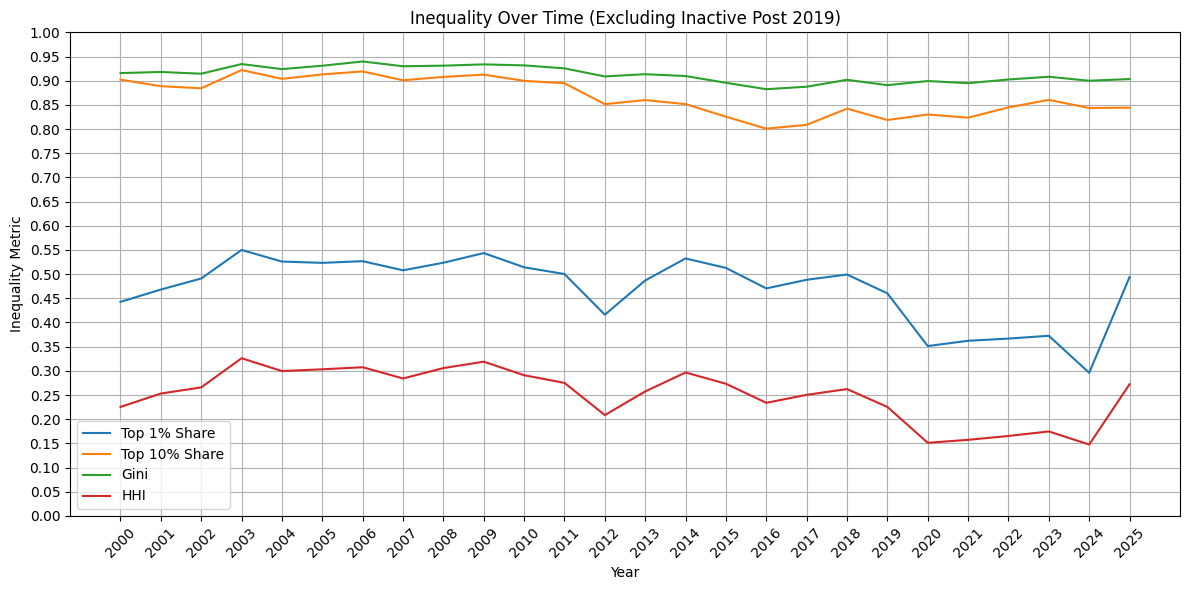

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_inequality["year"], df_inequality["top1_share"], label="Top 1% Share")
ax.plot(df_inequality["year"], df_inequality["top10_share"], label="Top 10% Share")
ax.plot(df_inequality["year"], df_inequality["gini"], label="Gini")
ax.plot(df_inequality["year"], df_inequality["hhi"], label="HHI")
years = df_inequality["year"].unique()
ax.set_xticks(years)
ax.tick_params(axis="x", rotation=45)
ax.set_yticks(np.arange(0, 1.05, .05))
ax.set_ylim(0, 1)
ax.set_xlabel("Year")
ax.set_ylabel("Inequality Metric")
ax.set_title("Inequality Over Time (Excluding Inactive Post 2019)")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Between 2000 and 2011, inequality is persistently high (Top 1% ≈ 50–55%, Gini ≈ 0.93). A drop in concentration occurs in 2012, followed by renewed concentration until 2014.

From 2016 onward, a sustained decline in inequality is observed across all metrics. Top 1% share falls from ~53% in 2014 to ~46% in 2019, with corresponding declines in Gini and HHI. This indicates organic diversification prior to the 2020 structural break.

Post-2020, concentration stabilises at a materially lower level (Top 1% ≈ 35–37%), suggesting the emergence of a more distributed reporting ecosystem.

The 2025 spike is attributed to partial-year effects and is excluded from structural interpretation.

## Growth Decomposition

We begin with the accounting identity:

`T = N x I`

Where:
* `T` = total occurances
* `N` = number of datasets
* `I` = mean occurences per dataset

We want to determine if growth in `T`, is being driven more by increases in `N` or increases in `I`. 

However if `N` grows by 10% and `I` grows by 10%, `T` doesn't grow by 20%, is grows by 21%. Because `1.1 x 1.1 = 1.21`.

This makes interpretation difficult. 

However by taking logs of both sides of the equation, the multiplicative relationship becomes additive. 

`logT = logN + logI`

`ΔlogT ≈ ΔlogN + ΔlogI`

In [87]:
df_year = df.groupby("year").agg(total_occurrences=("occurrenceCount", "sum"), n_datasets=("datasetKey", "nunique")).reset_index()

df_year["mean_intensity"] = df_year["total_occurrences"] / df_year["n_datasets"]

df_year = df_year.sort_values("year")

df_year["log_total"] = np.log(df_year["total_occurrences"])
df_year["log_n"] = np.log(df_year["n_datasets"])
df_year["log_intensity"] = np.log(df_year["mean_intensity"])

df_year["d_log_total"] = df_year["log_total"].diff()
df_year["d_log_n"] = df_year["log_n"].diff()
df_year["d_log_intensity"] = df_year["log_intensity"].diff()

df_year["check"] = df_year["d_log_n"] + df_year["d_log_intensity"]

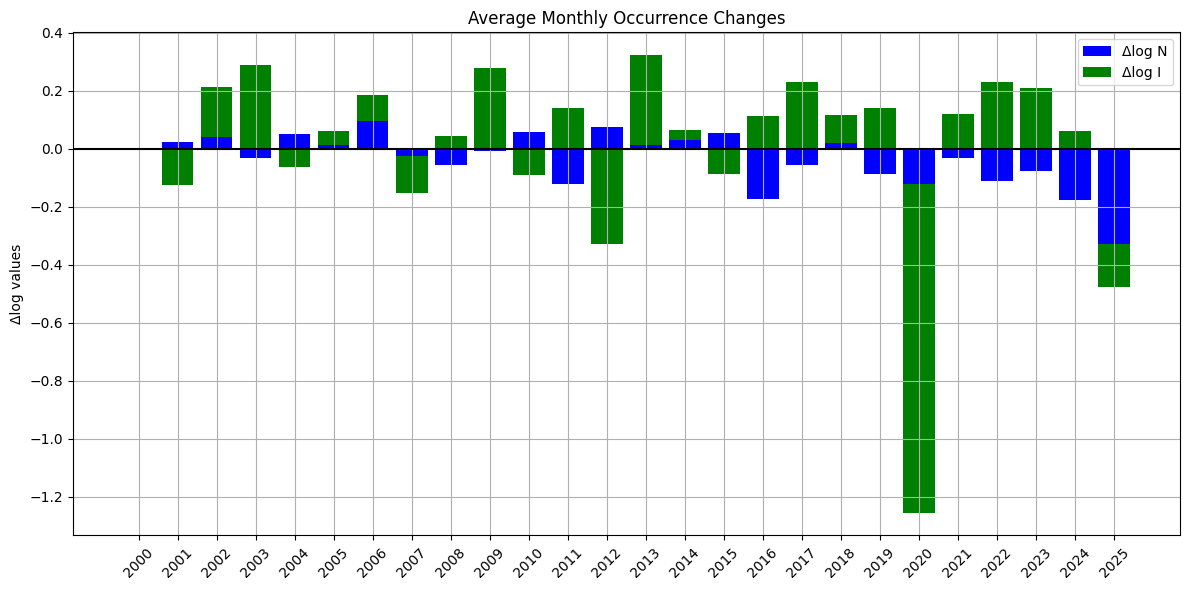

In [88]:
x = df_year['year'].values
dN = df_year["d_log_n"].values
dI = df_year["d_log_intensity"].values

plt.figure(figsize=(12, 6))

# Positive bars
plt.bar(x, np.where(dN > 0, dN, 0), label="Δlog N", color="blue")
plt.bar(x, np.where(dI > 0, dI, 0), bottom=np.where(dN>0, dN, 0), label="Δlog I", color="green")

# Negative bars
plt.bar(x, np.where(dN < 0, dN, 0), label=None, color="blue")
plt.bar(x, np.where(dI < 0, dI, 0), bottom=np.where(dN<0, dN, 0), label=None, color="green")

plt.axhline(y=0, color='black')

plt.xticks(years, rotation=45)
plt.title("Average Monthly Occurrence Changes")
plt.ylabel("Δlog values")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

We can clearly see that across the majority of years, change in the total number of occurences was driven mostly by changes in instensity. The exceptions to this rule are 2016, 2024, and 2025, where the number of datasets account for most of the change. The 2020 collapse is almost entirely attributed to a drop in the average intensity. This highlights the outsized role the top 1% of datasets had in shaping overall trends. 

Next we'll have a look at the same chart, with inactive datasets removed. 

##### Observations
* **2000–2018**: Growth episodes (e.g., 2003, 2006, 2009, 2013, 2017–2019) are almost entirely intensity-driven.
* **2020 collapse**: The −1.25 log-point contraction is almost entirely explained by a fall in intensity (−1.13), not dataset count (−0.12).
* **Exceptions**
    * 2016 and 2024 largerly driven by dataset contraction

##### Interpretation
This confirms a structurally important result: Aggregate dynamics are dominated by the intensive margin.

Increases in total activity are driven less by ecosystem expansion and more by changes in output per dataset. This aligns with earlier inequality results showing strong concentration: when dominant datasets expand or contract, aggregate totals move disproportionately.

The 2020 collapse is particularly revealing — it reflects a collapse in per-dataset activity rather than widespread dataset exit.

In [89]:
df_drop_inactive = df[df['activePost2019'] == True]
df_year = df_drop_inactive.groupby("year").agg(total_occurrences=("occurrenceCount", "sum"), n_datasets=("datasetKey", "nunique")).reset_index()

df_year["mean_intensity"] = df_year["total_occurrences"] / df_year["n_datasets"]

df_year = df_year.sort_values("year")

df_year["log_total"] = np.log(df_year["total_occurrences"])
df_year["log_n"] = np.log(df_year["n_datasets"])
df_year["log_intensity"] = np.log(df_year["mean_intensity"])

df_year["d_log_total"] = df_year["log_total"].diff()
df_year["d_log_n"] = df_year["log_n"].diff()
df_year["d_log_intensity"] = df_year["log_intensity"].diff()

df_year["check"] = df_year["d_log_n"] + df_year["d_log_intensity"]

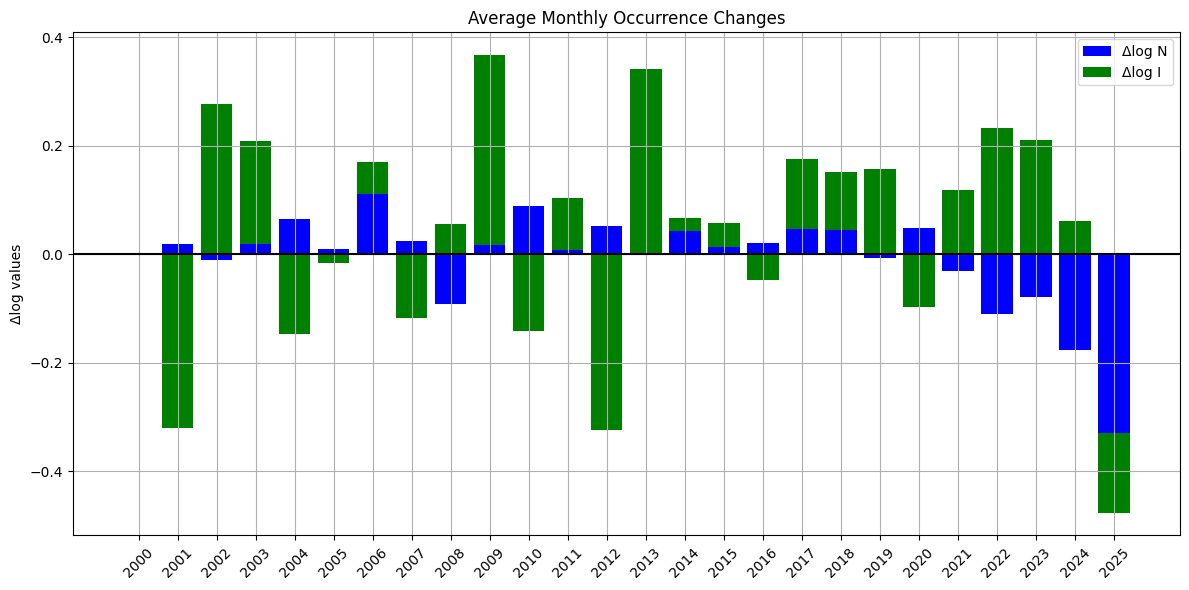

In [90]:
x = df_year['year'].values
dN = df_year["d_log_n"].values
dI = df_year["d_log_intensity"].values

plt.figure(figsize=(12, 6))

# Positive bars
plt.bar(x, np.where(dN > 0, dN, 0), label="Δlog N", color="blue")
plt.bar(x, np.where(dI > 0, dI, 0), bottom=np.where(dN>0, dN, 0), label="Δlog I", color="green")

# Negative bars
plt.bar(x, np.where(dN < 0, dN, 0), label=None, color="blue")
plt.bar(x, np.where(dI < 0, dI, 0), bottom=np.where(dN<0, dN, 0), label=None, color="green")

plt.axhline(y=0, color='black')

plt.xticks(years, rotation=45)
plt.title("Average Monthly Occurrence Changes")
plt.ylabel("Δlog values")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### Observations
2020 contraction is now modest (−0.048 log points).

This indicates that the dramatic 2020 collapse in the full sample was mechanically driven by the disappearance of historically dominant datasets.

Once those are excluded, the ecosystem appears far more stable.

In both specifications, 2024 and 2025 declines are driven primarily by reductions in dataset count. Given that 2025 is incomplete, this should not be interpreted structurally.

## Entry and Exit Dynamics

Understanding aggregate trends requires distinguishing between intensive growth within incumbent datasets and extensive-margin dynamics driven by entry and exit. This section examines whether ecosystem evolution is characterised by expansion, stable churn, or structural contraction.

In [91]:
df_lifespan = df.groupby("datasetKey")["year"].agg(firstYear="min", lastYear="max").reset_index()
df_lifespan["lifespan"] = df_lifespan["lastYear"] - df_lifespan["firstYear"] + 1
df_lifespan["activePost2019"] = df_lifespan["lastYear"] >= 2019

In [92]:
# drop old active_post_2019 column
df.drop(columns=['activePost2019'], inplace=True)
df = df.merge(df_lifespan, on='datasetKey', how='left')

### Gross Entry and Exit Flows

In [93]:
df_entry = df_lifespan.groupby('firstYear').agg(newDatasets=('datasetKey', 'count')).reset_index().rename(columns={'firstYear':'year'})
df_exit = df_lifespan.groupby('lastYear').agg(exitingDatasets=('datasetKey', 'count')).reset_index().rename(columns={'lastYear':'year'})

In [94]:
df_entry_exit = df_entry.merge(df_exit, on='year', how='outer').fillna(0).astype('int64')

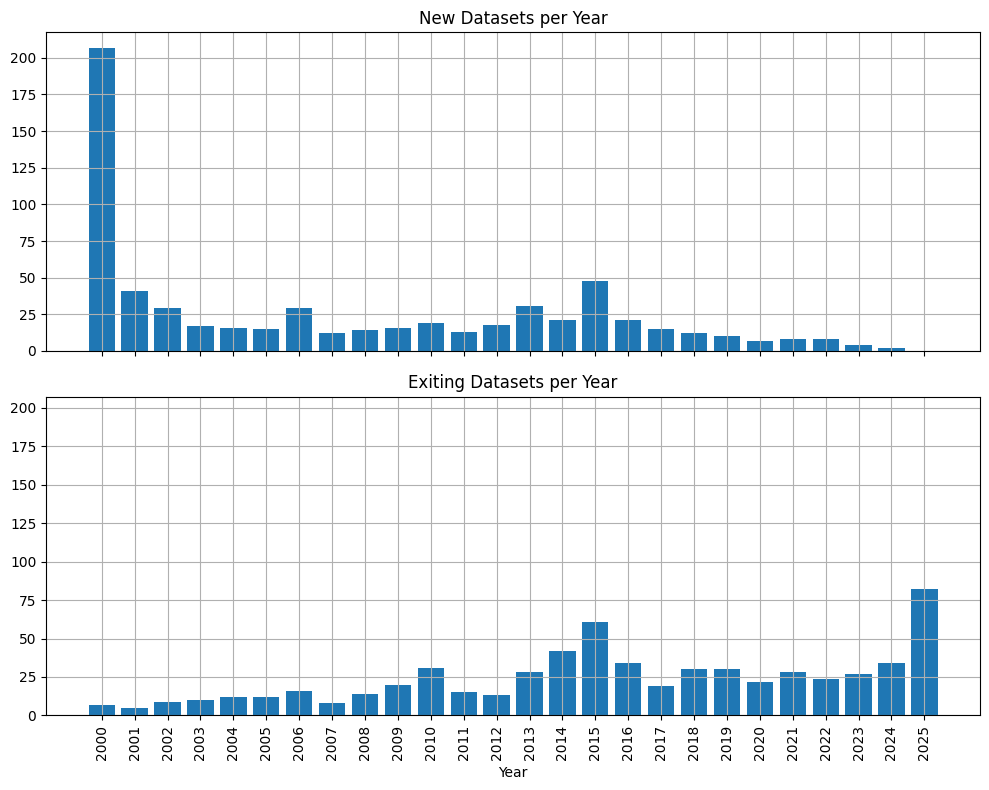

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top 1%
axes[0].bar(
    df_entry_exit['year'],
    df_entry_exit['newDatasets']
)
axes[0].set_title("New Datasets per Year")
axes[0].grid()

# Bottom 99%
axes[1].bar(
    df_entry_exit['year'],
    df_entry_exit['exitingDatasets']
)
axes[1].set_title("Exiting Datasets per Year")
axes[1].set_xlabel("Year")
axes[1].grid()

plt.xticks(ticks=df_entry_exit['year'], rotation=90)
plt.ylim(0, max(df_entry_exit['newDatasets'].max(), df_entry_exit['exitingDatasets'].max()))
fig.tight_layout()
plt.show()

The insect occurrence ecosystem shows high peripheral churn:

* Top 1% share rises steadily until 2018 despite continual entry/exit of smaller datasets.

* The 2019–2020 collapse is driven primarily by inactivity of historical core datasets, not by churn. 

* Post-2020, the system shows low entry and continued exits; 2025 metrics are likely affected by incomplete data.

Conclusion: Dataset dominance is driven by a small set of long-lived datasets, while the majority of datasets are short-lived. Entry and exit dynamics explain peripheral volatility but do not reduce overall concentration.

### Dataset Lifespan and Structural Hierarchy

In [96]:
df_lifespan = df_lifespan.merge(df[['datasetKey', 'tier']].drop_duplicates(), on='datasetKey', how="left")

In [97]:
df_lifespan.groupby("tier")["lifespan"].describe()

count       mean       std   min   25%   50%   75%   max
tier                                                              
Bottom90  570.0   8.798246  8.435614   1.0   1.0   5.0  16.0  26.0
Top1        6.0  22.166667  3.656045  17.0  20.0  22.5  25.0  26.0
Top10      57.0  21.368421  6.393723   2.0  17.0  24.0  26.0  26.0

* Bottom 90% datasets have short lifespans, with a median lifespan of 5 years and many active only 1 year.

* Top 10% datasets live much longer, with a median of 24 years, with 75% of them active for the entire period.

* Top 1% datasets are slightly less long lived than the top 10%, but still with nearly the entire period covered (median 22.5 years, max 26).

The longevity of datasets strongly correlates with dominance in occurence counts. The most influencial datasets are the most active year after year, while the majority of the datasets are transient. A small number of long lived datasets drives most of the global trends. 


### Survival Distribution

In [98]:
max_life = df_lifespan["lifespan"].max()

survival = []

for t in range(1, max_life+1):
    survival.append({
        "years": t,
        "survivalRate": (df_lifespan["lifespan"] >= t).mean()
    })

survival_df = pd.DataFrame(survival)

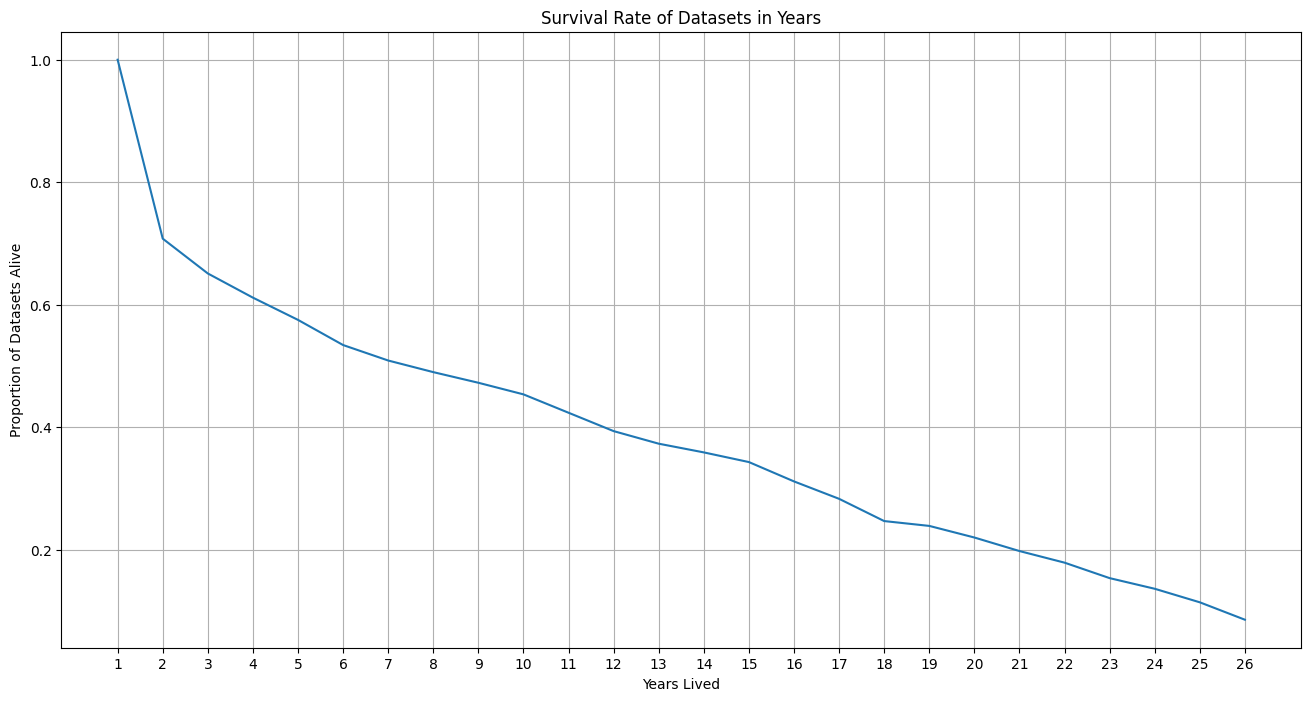

In [99]:
plt.figure(figsize=(16, 8))
plt.plot(survival_df['years'], survival_df['survivalRate'])
# plt.plot([0.01,0.01], [0.4,1], '--', color='red')
# plt.plot([0,1], [0.8,0.8], '--', color='red')
plt.title("Survival Rate of Datasets in Years")
plt.xticks(ticks=survival_df['years'])
plt.xlabel("Years Lived")
plt.ylabel("Proportion of Datasets Alive")
plt.grid()
plt.show()

30% of datasets don't span longer than a single year, and almost 40% don't last 4 years. The survival rate gradually declines year by year, with only 8.5% of datasets surviving the full time span. 

### Interpretation

Taken together, the entry–exit evidence shows:
* Early ecosystem expansion was driven by entry.
* Long-run scale is not sustained by continuous inflow.
* Growth is not primarily entrant-driven.
* Dominance is tightly linked to longevity.
* Recent contraction reflects exit outpacing entry.

The ecosystem exhibits a persistent core–periphery structure:
* A small number of long-lived, dominant datasets.
* A large mass of short-lived peripheral participants.

Extensive-margin churn exists, but structural influence resides with durable incumbents.

## Core features

* Lagged values (t-1, t-3, t-12)
* Rolling means and standard deviations
* Month encoded as cyclical features
* Effort normalised counts

## Rationale

Explain why each feature is made

## Expected Outcome

* Feature matrix suitable for superivsed learning

* Clear feature documentation